In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statistics
import re

## data-cons.csv

Datos agregados de consumo, que tienen :
- ID: La información de cuatro edificios, cada entrada con un identificador
- IDdispositivo: Un idenficador de dispositivo que hace referencia al edificio (cuatro valores distintos, 335546925 (?), 335546926 (B), 335546927 (C), 335546928 (A))
- Fecha: La fecha de la entrada: desde el 2021-01-01 al 2021-12-31
- V22: El consumo en dicha fecha

Estos datos son obtenidos de la base de datos.

In [208]:
data = pd.read_csv('data-cons.csv')
print(data.shape)
data.head(3)

(206445, 4)


,ID,IDdispositivo,Fecha,V22
0,4872243,335546925,2021-12-31 23:56:08.958+01,1.136745e+06
1,4872244,335546926,2021-12-31 23:56:08.958+01,8.510530e+04
2,4872242,335546928,2021-12-31 23:56:08.958+01,1.884996e+05


## cons_.csv
- Fecha
- dif_cons: diferencias en el consumo en intervalos de 10 minutos
- cons_total: consumo acumulado

Se obtiene de data-cons.csv

Fecha de inicio: 2021-01-01 00:00:01+00:00 <br>
Fecha de final: 2021-12-18 00:00:01+00:00

En total tenemos 52560 datos para cada edificio

In [220]:
def cons(ids_edificio, edificio, datos, interval):
    data = datos
    ids = ids_edificio
    #Nos quedamos solo con uno de los edificios
    mask = data['IDdispositivo'].isin(ids)
    df = data.loc[mask]
    df = df.iloc[::-1]
    #Creamos una columna que sea la diferencia de consumo entre t y t-1
    df.insert(2, "dif_cons", df['V22'].diff(), True)
    df = df.set_index('Fecha')
    df.index = pd.to_datetime(df.index, utc = True)
    #Hacemos un remuestreo cada <interval> (10|30|60 min)
    df = df.resample(interval)['dif_cons'].sum().to_frame()
    #Creamos una columna que sea el consumo acumulado hasta el t actual
    df.insert(1, "cons_total", df['dif_cons'].cumsum(), True)
    
    #Problema: 0's que no se pueden justificar desde 32132 a 32687 y desde 49489 a 49873 y que dan lugar a 
    #dos saltos muy grandes en "dif_cons" y "cons_total". Esto supone un problema importante a la hora de
    #evaluar el modelo.
    #Para arreglarlo: no se puede hacer una interpolación directamente ya que no hay valores nulos
    #y en "dif_cons" no tiene sentido hacer interpolación lineal. Lo que hacemos es detectar con regex esa
    #secuencia de ceros, que definimos como más de diez ceros (solo se cumple en esos dos casos), una vez
    #tenemos los índices de los ceros reescribimos todas esas entradas, tanto en "dif_cons" como en "cons_total"
    #como nulos. Interpolamos en la columna de "cons_total" que sí tiene un comportamiento que se puede 
    #enterder como lineal y con ella calculamos "dif_cons", de forma que los valores que no daban problemas
    #siguen igual pero lo que sí daban ahora están arreglados
    
    def first_digit(num): return int(str(num)[0])
    result = [first_digit(n) for n in df['dif_cons']*100]
    text=pd.Series(result).astype(int).astype(str).str.cat()
    sequence = list(np.repeat(str(0),10))
    sequence.insert(len(sequence),'+')
    sequence= ''.join(sequence)
    pattern = f'({sequence})'
    findings = re.finditer(pattern, text)
    events = [(m.start(0), m.end(0)) for m in findings]
    
    df.iloc[events[0][0]:events[0][1] ,:] = np.nan
    df.iloc[events[1][0]:events[1][1] ,:] = np.nan
    
    #df['cons_total'] = df['cons_total'].interpolate(method='linear', axis=0)
    df['cons_total'] = df['cons_total'].interpolate(method='cubic', axis=0)
    df['dif_cons'] = df['cons_total'].diff().fillna(0)    
    
    #Ruido para que no sea tan suave (?)
    mu = np.mean(df.iloc[events[0][0]:events[0][1] ,0])
    df.iloc[events[0][0]:events[0][1] ,0] = np.random.normal(mu, 0.1, len(df.iloc[events[0][0]:events[0][1] ,0]))
    mu = np.mean(df.iloc[events[1][0]:events[1][1] ,0])
    df.iloc[events[1][0]:events[1][1] ,0] = np.random.normal(mu, 0.1, len(df.iloc[events[1][0]:events[1][1] ,0]))
    
    #Fijamos el límite de la fecha hasta cuando tenemos datos meteorológicos
    mask = (df.index >= '2021-01-01 00:00:00') & (df.index <= '2021-12-18 00:00:01')
    df = df.loc[mask]
    
    df.to_csv('cons'+ edificio + '-' + interval + '.csv', sep=";")

In [4]:
res_time = '10T'

In [228]:
cons([335546928], 'A', data, res_time)
cons([335546926], 'B', data, res_time)
cons([335546927], 'C', data, res_time)

In [5]:
consA = pd.read_csv('consA-' + res_time + '.csv', sep=";")
consB = pd.read_csv('consB-' + res_time + '.csv', sep=";")
consC = pd.read_csv('consC-' + res_time + '.csv', sep=";")
consA.head()

,Fecha,dif_cons,cons_total
0,2021-01-01 00:00:00+00:00,0.218750,1.312500
1,2021-01-01 00:10:00+00:00,0.234375,1.546875
2,2021-01-01 00:20:00+00:00,0.218750,1.765625
3,2021-01-01 00:30:00+00:00,0.203125,1.968750
4,2021-01-01 00:40:00+00:00,0.234375,2.203125


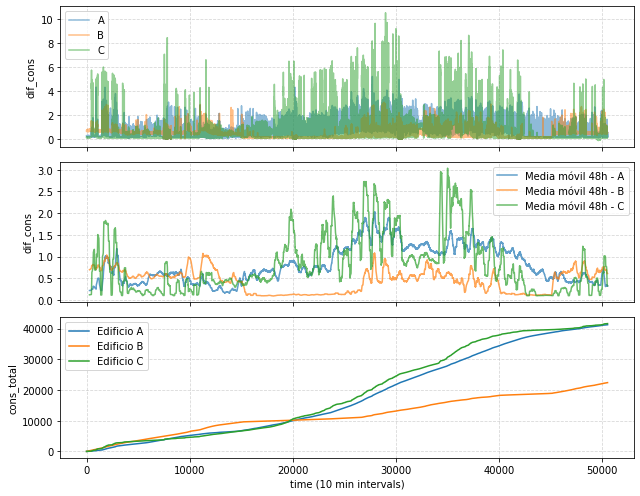

In [271]:
fig, axs = plt.subplots(figsize=(9,7), nrows = 3, ncols =1, sharex =True)

axs[0].plot(consA['dif_cons'], label="Edificio A", alpha=0.5)
axs[0].plot(consB['dif_cons'], label="Edificio B", alpha=0.5)
axs[0].plot(consC['dif_cons'], label="Edificio C", alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.5)
axs[0].legend(loc="upper left")
axs[0].set_ylabel("dif_cons")

#Media móvil de 2 días
axs[1].plot(consA['dif_cons'].rolling(144*2).mean(), label="Media móvil 48h - A", alpha=0.7)
axs[1].plot(consB['dif_cons'].rolling(144*2).mean(), label="Media móvil 48h - B", alpha=0.7)
axs[1].plot(consC['dif_cons'].rolling(144*2).mean(), label="Media móvil 48h - C", alpha=0.7)
axs[1].grid(linestyle = "--", alpha=0.5)
axs[1].set_ylabel("dif_cons")
axs[1].legend()

axs[2].plot(consA['cons_total'], label = "Edificio A")
axs[2].plot(consB['cons_total'], label = "Edificio B")
axs[2].plot(consC['cons_total'], label = "Edificio C")
axs[2].grid(linestyle = "--", alpha=0.5)
axs[2].set_ylabel("cons_total")
axs[2].set_xlabel('time (10 min intervals)')
axs[2].legend()
fig.tight_layout()
plt.show()

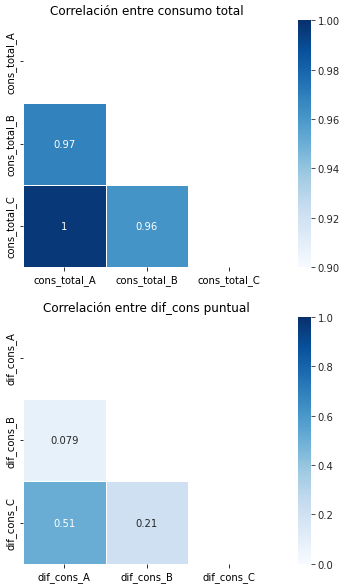

In [18]:
df1 = pd.merge(consA[['Fecha','cons_total']],consB[['Fecha','cons_total']], on = "Fecha", suffixes=('_A', '_B'))
df2 = pd.merge(df1[['Fecha','cons_total_A', 'cons_total_B']],consC[['Fecha','cons_total']], on = "Fecha").rename(columns={"cons_total": "cons_total_C"})
df2.rename(columns={"cons_total": "cons_total_C"})
df3 = pd.merge(consA[['Fecha','dif_cons']],consB[['Fecha','dif_cons']], on = "Fecha", suffixes=('_A', '_B'))
df4 = pd.merge(df3[['Fecha','dif_cons_A', 'dif_cons_B']],consC[['Fecha','dif_cons']], on = "Fecha").rename(columns={"dif_cons": "dif_cons_C"})
df4.rename(columns={"dif_cons": "dif_cons_C"})
corr_cons_total=df2.corr()
corr_dif=df4.corr()
mask1 = np.zeros_like(corr_cons_total)
mask1[np.triu_indices_from(mask1)] = True
mask2 = np.zeros_like(corr_cons_total)
mask2[np.triu_indices_from(mask2)] = True

fig, axs = plt.subplots(figsize = (10,10), nrows = 2, ncols =1) # width x height
#ax1 = fig.add_subplot(1, 1, 1) # row, column, position
#ax2 = fig.add_subplot(2, 1, 2)
with sns.axes_style("white"):
    axs[0] = sns.heatmap(corr_cons_total, ax=axs[0],
                     xticklabels=corr_cons_total, yticklabels=corr_cons_total,
                     mask=mask1, vmin=0.9, vmax=1, square=True,
                     annot = True, linewidths=.5, cmap="Blues")
    axs[0].set_title('Correlación entre consumo total')
    axs[1] = sns.heatmap(corr_dif, ax=axs[1],
                 xticklabels=corr_dif, yticklabels=corr_dif,
                 mask=mask2, vmin=0, vmax=1, square=True,
                 annot = True, linewidths=.5, cmap="Blues")
    axs[1].set_title('Correlación entre dif_cons puntual')

## data-sensor.csv
- Id
- IDdispositivo: ids de los sensores, tenemos para <br>
 - edificio A: [335544455, 335544458, 335544461, 335544472, 335544479, 335544488,
       335544491, 335544499, 335544506, 335544517, 335544522, 335544529,
       335544532, 335544542, 335544547, 335544554, 335544557, 335544563,
       335544569, 335544575, 335544605, 335544613, 335544628, 335544639,
       335544648, 335544655, 335544660, 335544672, 335544736, 335544739,
       335544747, 335544750, 335544764, 335544770, 335544790, 335544791,
       335544792, 335544811, 335544812, 335544979, 335545134, 335547743,
       335547759, 335547765, 335547778, 335547785, 335547798, 335547804,
       335547817]<br>
 
 - edificio B: [335544685, 335544692, 335544699, 335544720, 335544721, 335544823,
       335544830, 335544838, 335544857, 335544858, 335544863, 335544977,
       335545020, 335545055, 335545056, 335545087, 335545091, 335547856,
       335547861, 335547871, 335547879, 335547886, 335547887, 335547901,
       335547902, 335547903, 335547925, 335547926, 335547940, 335547950,
       335547951, 335547965, 335547966, 335547967, 335548038] <br>

 - edificio C: [335544931, 335544934, 335544941, 335544948, 335545128, 335545129]
- Fecha
- V2: temperatura de la habitación registrada por los sensores

Estos datos son obtenidos de la base de datos.

In [4]:
data = pd.read_csv('data-sensor.csv', sep=';')

In [5]:
print(data.shape)
data.head(3)

(9857796, 3)


,IDdispositivo,Fecha,V2
0,335544547,2021-12-31 23:55:19.635+01,22.659363
1,335544544,2021-12-31 23:55:19.635+01,5.000000
2,335544543,2021-12-31 23:55:19.635+01,34.481567


## temp-sensor_.csv

- Fecha
- V2: temperatura del sensor, agregada con resample de 10min, con valores limitados entre 15 y 38 grados. Este dato es la media de lo recogido por los sensores de cada habitación

Se obtiene de data-sensor.csv

Los ids de los sensores para cada uno de los edificios los obtenemos de relations-sensor.csv viendo los valores que toma el campo 'ID' haciendo un where en 'block', y son los siguientes:

Hacemos los fichero temp_sensor_.csv para cada uno de los edificios:

In [6]:
ids_sensor_A = [335544455, 335544458, 335544461, 335544472, 335544479, 335544488, 335544491, 335544499, 335544506, 335544517, 335544522, 335544529, 335544532, 335544542, 335544547, 335544554, 335544557, 335544563, 335544569, 335544575, 335544605, 335544613, 335544628, 335544639, 335544648, 335544655, 335544660, 335544672, 335544736, 335544739, 335544747, 335544750, 335544764, 335544770, 335544790, 335544791, 335544792, 335544811, 335544812, 335544979, 335545134, 335547743, 335547759, 335547765, 335547778, 335547785, 335547798, 335547804, 335547817]
ids_sensor_B = [335544685, 335544692, 335544699, 335544720, 335544721, 335544823,335544830, 335544838, 335544857, 335544858, 335544863, 335544977, 335545020, 335545055, 335545056, 335545087, 335545091, 335547856, 335547861, 335547871, 335547879, 335547886, 335547887, 335547901, 335547902, 335547903, 335547925, 335547926, 335547940, 335547950, 335547951, 335547965, 335547966, 335547967, 335548038]
ids_sensor_C = [335544931, 335544934, 335544941, 335544948, 335545128, 335545129]

In [7]:
def temp_sensor(ids_sensor, edificio, datos, interval):
    ids = ids_sensor
    data = datos
    #Tomamos los datos correspondientes a uno de los edificios
    mask = data['IDdispositivo'].isin(ids)
    df = data.loc[mask]
    
    df = df.sort_values(by=['IDdispositivo', 'Fecha'], ascending=True)
    #Ponemos valores extremos o erróneos como nulos y los reescribimos con el un valor anterior válido
    mask = (data['V2']<15) | (data['V2']>40)
    data.loc[mask, 'V2'] = np.nan
    df['V2'] = df['V2'].fillna(method="ffill")
    
    df = df.sort_values(by=['Fecha'], ascending=False)
    df = df.set_index('Fecha')
    df.index = pd.to_datetime(df.index, utc = True)
    #Remuestreo en V2 haciendo media de temperaturas y de nuevo reescribimos nulos
    df = df.groupby('IDdispositivo').resample(interval)['V2'].mean().to_frame()
    df['V2'] = df['V2'].fillna(method="ffill")
    df = df.reset_index()
    #Agrupamos por fecha
    df = df[['Fecha', 'V2']].groupby('Fecha').mean()

    #Fijamos el límite de la fecha hasta cuando tenemos datos meteorológicos
    mask = (df.index >= '2021-01-01 00:00:01') & (df.index <= '2021-12-18 00:00:01')
    df = df.loc[mask]
    
    df.to_csv('temp-sensor' + edificio + '-' + interval + '.csv', sep=";")

In [8]:
res_time = '120T'

In [9]:
temp_sensor(ids_sensor_A, 'A', data, res_time)
temp_sensor(ids_sensor_B, 'B', data, res_time)
temp_sensor(ids_sensor_C, 'C', data, res_time)

In [51]:
temp_sensorA = pd.read_csv('temp-sensorA-' + res_time + '.csv', sep=";")
temp_sensorB = pd.read_csv('temp-sensorB-' + res_time + '.csv', sep=";")
temp_sensorC = pd.read_csv('temp-sensorC-' + res_time + '.csv', sep=";")
temp_sensorA.head(3)

,Fecha,V2
0,2021-01-01 00:00:00+00:00,22.762425
1,2021-01-01 00:10:00+00:00,22.750655
2,2021-01-01 00:20:00+00:00,22.741760


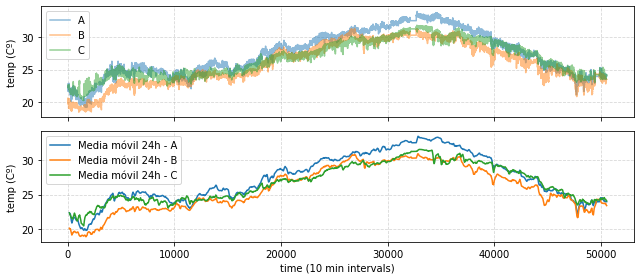

In [52]:
fig, axs = plt.subplots(figsize=(9,4), nrows = 2, ncols =1, sharex =True)

axs[0].plot(temp_sensorA['V2'], label = "A", alpha = 0.5)
axs[0].plot(temp_sensorB['V2'], label = "B", alpha = 0.5)
axs[0].plot(temp_sensorC['V2'], label = "C", alpha = 0.5)
axs[0].grid(linestyle = "--", alpha=0.5)
axs[0].set_ylabel('temp (Cº)')
axs[0].legend(loc="upper left")
axs[1].plot(temp_sensorA['V2'].rolling(144).mean(),label= 'Media móvil 24h - A')
axs[1].plot(temp_sensorB['V2'].rolling(144).mean(),label= 'Media móvil 24h - B')
axs[1].plot(temp_sensorC['V2'].rolling(144).mean(),label= 'Media móvil 24h - C')
axs[1].legend(loc="upper left")
axs[1].grid(linestyle = "--", alpha=0.5)
axs[1].set_xlabel('time (10 min intervals)')
axs[1].set_ylabel('temp (Cº)')
fig.tight_layout()
plt.show()

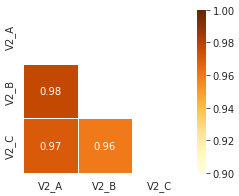

In [52]:
df1 = pd.merge(temp_sensorA[['Fecha','V2']],temp_sensorB[['Fecha','V2']], on = "Fecha", suffixes=('_A', '_B'))
df2 = pd.merge(df1[['Fecha','V2_A', 'V2_B']],temp_sensorC[['Fecha','V2']], on = "Fecha").rename(columns={"V2": "V2_C"})
df2.rename(columns={"V2": "V2_C"})
corr=df2.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(4, 3))
    ax = sns.heatmap(corr, 
                     xticklabels=corr, yticklabels=corr,
                     mask=mask, vmin=0.9, vmax=1, square=True,
                     annot = True, linewidths=.5, cmap="YlOrBr")

## data-hvac.csv
- ID
- IDdispositivo: identificador del hvac
- Fecha
- V4: indica el estado, 0 si es OFF, 1 si es ON
- V5: Modo de operación (byte) (editable):
    * 0 = no establecido en escritura (realmente no se va a escribir ese valor nunca) e inválido en lectura
    * 1 = calor
    * 2 = frío
    * 3 = seco
    * 4 = ventilador
    * 5 = auto en escritura, y auto heat en lectura
    * 6 = auto cool en lectura
    * 7 = no establecido en lectura
- V12: temperatura de consigna / setpoint
- V26: tipo de sistema (pared/techo)

In [10]:
data = pd.read_csv("data-hvac.csv")
print(data.shape)
data.tail(3)

(4339076, 7)


,IDdispositivo,Fecha,V4,V5,V6,V12,V26
4339073,335545207,2021-01-01 00:00:59.868+01,0,0,0,0.0,2
4339074,335545209,2021-01-01 00:00:59.868+01,0,0,0,0.0,2
4339075,335545211,2021-01-01 00:00:59.868+01,0,0,0,0.0,2


In [20]:
data.describe()

,IDdispositivo,V4,V5,V6,V12,V26
count,4.339076e+06,4.339076e+06,4.339076e+06,4.339076e+06,4.339076e+06,4.339076e+06
mean,3.355452e+08,1.410397e-01,1.604413e+00,2.725108e+00,2.023009e+01,1.874848e+00
std,5.085389e+01,3.480625e-01,5.462351e-01,9.648639e-01,7.954862e+00,3.308910e-01
min,3.355451e+08,0.000000e+00,0.000000e+00,0.000000e+00,-3.500000e+01,1.000000e+00
25%,3.355452e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.100000e+01,2.000000e+00
50%,3.355452e+08,0.000000e+00,2.000000e+00,3.000000e+00,2.200000e+01,2.000000e+00
75%,3.355453e+08,0.000000e+00,2.000000e+00,3.000000e+00,2.400000e+01,2.000000e+00
max,3.355453e+08,1.000000e+00,4.000000e+00,5.000000e+00,6.800000e+01,2.000000e+00


In [32]:
data['V5'].value_counts()

2    2711095
1    1501110
0     114369
3      11638
4        864
Name: V5, dtype: int64

In [4]:
def V26_change(datos):
    if datos == 1: return 2
    if datos == 2: return 1

In [5]:
#data['V26'].apply(V26_change).value_counts()

## hvac-mixed_.csv

In [11]:
ids_hvac_A = [335545141, 335545231, 335545233, 335545239, 335545235, 335545237, 335545221, 335545223, 335545225, 335545227, 335545229, 335545245, 335545241, 335545243, 335545251, 335545253, 335545255, 335545249, 335545247, 335545257, 335545259, 335545263, 335545261, 335545265, 335545267, 335545269, 335545277, 335545279, 335545281, 335545271, 335545275, 335545273, 335545283, 335545285, 335545287, 335545293, 335545289, 335545291, 335545301, 335545295, 335545297, 335545299, 335545303, 335545305, 335545307, 335545309, 335545311, 335545313, 335545315]
ids_hvac_B = [335545147, 335545149, 335545143, 335545163, 335545165, 335545161, 335545155, 335545153, 335545159, 335545151, 335545157, 335545203, 335545205, 335545201, 335545197, 335545199, 335545217, 335545219, 335545213, 335545215, 335545207, 335545209, 335545211]
ids_hvac_C = [335545193, 335545191, 335545189, 335545187, 335545183, 335545177, 335545181, 335545179, 335545185, 335545167, 335545169, 335545171, 335545175, 335545173]

In [6]:
#def mode(nums):
#    try:
#        return statistics.mode(nums)
#    except statistics.StatisticsError:
#        return 0

In [12]:
def hvac_mixed(ids_hvac, edificio, datos, interval):
    data = datos
    ids = ids_hvac
    mask = data['IDdispositivo'].isin(ids)
    df = data.loc[mask]

    #Ordenamos por ID y fecha para tener todos los registros de cada hvac seguidos y además ordenaods por fecha
    #Después cambiamos los 0's de V12 por nulos y hacemos foward fill para reemplazarlo por el último valor no nulo
    df = df.sort_values(by=['IDdispositivo', 'Fecha'], ascending=True)
    mask = (data['V12']<=0) | (data['V12']>60)
    data.loc[mask, 'V12'] = np.nan
    df['V12'] = df['V12'].fillna(method="ffill")

    #Reeordenamos por fecha
    df = df.sort_values(by=['Fecha'], ascending=False)
    df0 = df.set_index('Fecha')
    df0.index = pd.to_datetime(df0.index, utc = True)
    
    #Resample para V4
    df1 = df0.groupby('IDdispositivo').resample(interval)['V4'].mean().to_frame()
    df1 = df1.reset_index()
    dfON = df1[['Fecha', 'V4']].groupby(['Fecha']).sum().round(0)
    
    #Resample para V12
    df2 = df0.groupby('IDdispositivo').resample(interval)['V12'].mean().to_frame().reset_index()
    df2['V12'] = df2['V12'].fillna(method="ffill")
    dfSETpoint = df2[['Fecha', 'V12']].groupby(['Fecha']).mean().round(2)
    
    #Resample para V5, aquí nos quedamos con el modo del hvac que devuelva la mediana
    #No usamos moda porque no va
    df3 = df0.groupby('IDdispositivo').resample(interval)['V5'].median().to_frame().reset_index()
    df3['V5'] = df3['V5'].fillna(method="ffill")
    dfV5median = df3[['Fecha', 'V5']].groupby(['Fecha']).median()
    
    #En edificio A todos son de tipo 2, en B y C hay de ambos.
    #Si V4 es 0, ponemos V26=0, así lo que tenemos es V26 = 0 (apagado), = 1 (pared), = 2 (techo)
    #En el resample hacemos una media, que nos dará un índice 0 <= x <= 2, que podríamos interpretar
    #como la relación entre los tipos de funcionamiento en un momento dado.
    #Importante: ¿Gasta más el de pared o el de techo? Si gasta más el de pared habría que intercambiar
    # 1 por 2 para que sean valores enteros ordenados con sentido
    mask = (df0['V4']==0)
    df0.loc[mask, 'V26'] = 0
    df4 = df0.groupby('IDdispositivo').resample(interval)['V26'].mean().round(1).to_frame().reset_index()
    df4['V26'] = df4['V26'].fillna(method="ffill")
    dfV26median = df4[['Fecha', 'V26']].groupby(['Fecha']).mean().round(1)
    
    #Unimos los dataframes y creamos dummies para el modo del hvac (0=apagado, 1=calor, 2=frio)
    #Recordar que es normal que salgan pocos 0's porque estamos teniendo en cuenta el total de hvac
    #para cada instante de tiempo
    mixed = dfON.merge(dfSETpoint, left_index=True, right_index=True, how='outer')
    mixed = mixed.merge(dfV5median, left_index=True, right_index=True, how='outer')
    mixed = mixed.merge(dfV26median, left_index=True, right_index=True, how='outer')
    mixed['V5'] = mixed['V5'].astype(int)
    #Y para arreglar las inconsistencias de que cuando V4 es 0, el modo no sea 0, utilizamos esta mask
    mask = (mixed['V4']==0)
    mixed.loc[mask, 'V5'] = 0
    mixed = pd.concat([mixed, pd.get_dummies(mixed.V5, prefix='V5')], axis=1).drop(columns=['V5'])
    
    #Añadimos otra variable que divida el día en tres partes (mañana/tarde/noche) y la ponemos también como dummy
    def hora_(Hora):
        if Hora in range(6,14): return 1
        if Hora in range(14,22): return 2
        if Hora in [22,23,0,1,2,3,4,5]: return 3

    mixed['Hora'] = mixed.index.hour
    mixed['Hora'] = mixed['Hora'].apply(hora_).astype(int)
    mixed = pd.concat([mixed, pd.get_dummies(mixed.Hora, prefix='Hora')], axis=1).drop(columns=['Hora'])

    def season(Mes):
        if Mes in range(1,4): return 1
        if Mes in range(4,7): return 2
        if Mes in range(7,10): return 3
        if Mes in range(10,13): return 4
    
    mixed['Season'] = mixed.index.month
    mixed['Season'] = mixed['Season'].apply(season).astype(int)
    mixed = pd.concat([mixed, pd.get_dummies(mixed['Season'], prefix='Season')], axis=1).drop(columns=['Season'])
    
    #Fijamos el límite de la fecha hasta cuando tenemos datos meteorológicos
    mask = (mixed.index >= '2021-01-01 00:00:00') & (mixed.index <= '2021-12-18 00:00:01')
    mixed = mixed.loc[mask]
    
    mixed.to_csv('hvac-mixed' + edificio + '-' + interval + '.csv', sep=";")

In [13]:
res_time = '120T'

In [14]:
hvac_mixed(ids_hvac_A, 'A', data, res_time)
hvac_mixed(ids_hvac_B, 'B', data, res_time)
hvac_mixed(ids_hvac_C, 'C', data, res_time)

In [51]:
hvac_mixedA = pd.read_csv('hvac-mixedA-' + res_time + '.csv', sep=";")
hvac_mixedB = pd.read_csv('hvac-mixedB-' + res_time + '.csv', sep=";")
hvac_mixedC = pd.read_csv('hvac-mixedC-' + res_time + '.csv', sep=";")
hvac_mixedC.head(3)

,Fecha,V4,V12,V26,V5_0,V5_1,V5_2,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:00:00+00:00,0.0,25.14,0.0,1,0,0,0,0,1,1,0,0,0
1,2021-01-01 00:10:00+00:00,0.0,25.14,0.0,1,0,0,0,0,1,1,0,0,0
2,2021-01-01 00:20:00+00:00,0.0,25.14,0.0,1,0,0,0,0,1,1,0,0,0


In [52]:
hvac_mixedA['V26'].value_counts()

0.3    16769
0.4    15207
0.1     7277
0.2     6813
0.5     2368
0.0     1428
0.6      504
0.7      168
0.8       11
Name: V26, dtype: int64

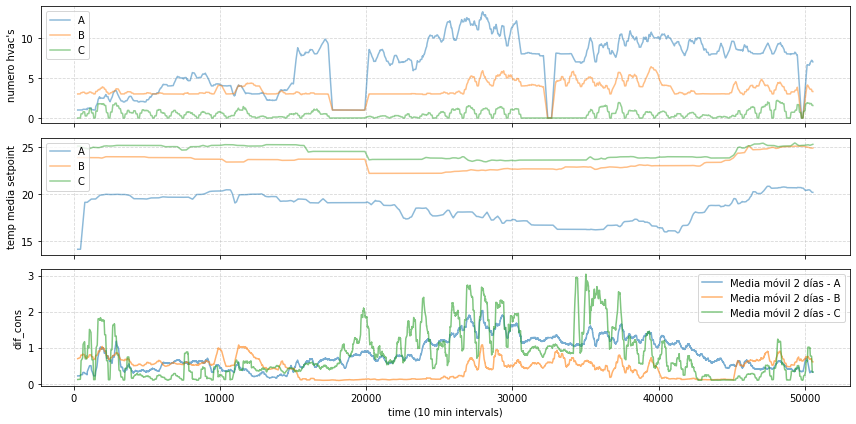

In [24]:
fig, axs = plt.subplots(figsize=(12,6), nrows = 3, ncols =1, sharex =True)

axs[0].plot(hvac_mixedA['V4'].rolling(144*2).mean(), label="A", alpha=0.5)
axs[0].plot(hvac_mixedB['V4'].rolling(144*2).mean(), label="B", alpha=0.5)
axs[0].plot(hvac_mixedC['V4'].rolling(144*2).mean(), label="C", alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.5)
axs[0].legend(loc="upper left")
axs[0].set_ylabel("numero hvac's")

axs[1].plot(hvac_mixedA['V12'].rolling(144*2).mean(), label="A", alpha=0.5)
axs[1].plot(hvac_mixedB['V12'].rolling(144*2).mean(), label="B", alpha=0.5)
axs[1].plot(hvac_mixedC['V12'].rolling(144*2).mean(), label="C", alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.5)
axs[1].legend(loc="upper left")
axs[1].set_ylabel("temp media setpoint")

#Media móvil de 1 semana
axs[2].plot(consA['dif_cons'].rolling(144*2).mean(), label="Media móvil 2 días - A", alpha=0.6)
axs[2].plot(consB['dif_cons'].rolling(144*2).mean(), label="Media móvil 2 días - B", alpha=0.6)
axs[2].plot(consC['dif_cons'].rolling(144*2).mean(), label="Media móvil 2 días - C", alpha=0.6)
axs[2].grid(linestyle = "--", alpha=0.5)
axs[2].set_ylabel("dif_cons")
axs[2].set_xlabel('time (10 min intervals)')
axs[2].legend()

fig.tight_layout()
plt.show()

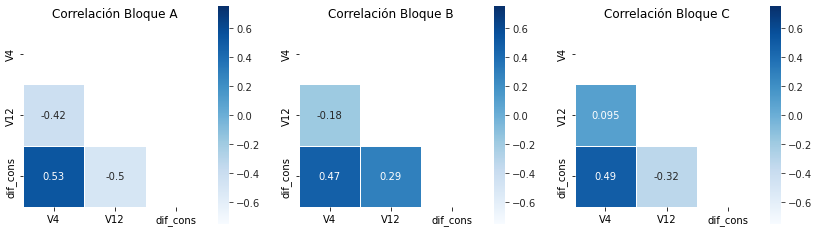

In [49]:
df1 = pd.merge(hvac_mixedA[['Fecha','V4']],hvac_mixedA[['Fecha','V12']], on = "Fecha")
df2 = pd.merge(df1[['Fecha','V4', 'V12']],consA[['Fecha','dif_cons']], on = "Fecha")
df3 = pd.merge(hvac_mixedB[['Fecha','V4']],hvac_mixedB[['Fecha','V12']], on = "Fecha")
df4 = pd.merge(df3[['Fecha','V4', 'V12']],consB[['Fecha','dif_cons']], on = "Fecha")
df5 = pd.merge(hvac_mixedC[['Fecha','V4']],hvac_mixedC[['Fecha','V12']], on = "Fecha")
df6 = pd.merge(df5[['Fecha','V4', 'V12']],consC[['Fecha','dif_cons']], on = "Fecha")
#df2.rename(columns={"cons_total": "cons_total_C"})
#df3 = pd.merge(consA[['Fecha','dif_cons']],consB[['Fecha','dif_cons']], on = "Fecha", suffixes=('_A', '_B'))
#df4 = pd.merge(df3[['Fecha','dif_cons_A', 'dif_cons_B']],consC[['Fecha','dif_cons']], on = "Fecha").rename(columns={"dif_cons": "dif_cons_C"})
#df4.rename(columns={"dif_cons": "dif_cons_C"})
corr_A=df2.corr()
corr_B=df4.corr()
corr_C=df6.corr()
mask1 = np.zeros_like(corr_A)
mask1[np.triu_indices_from(mask1)] = True
mask2 = np.zeros_like(corr_B)
mask2[np.triu_indices_from(mask2)] = True
mask3 = np.zeros_like(corr_C)
mask3[np.triu_indices_from(mask2)] = True

fig, axs = plt.subplots(figsize = (14,4), nrows = 1, ncols =3) # width x height
#ax1 = fig.add_subplot(1, 1, 1) # row, column, position
#ax2 = fig.add_subplot(2, 1, 2)
with sns.axes_style("white"):
    axs[0] = sns.heatmap(corr_A, ax=axs[0],
                     xticklabels=corr_A, yticklabels=corr_A,
                     mask=mask1, vmin=-0.75, vmax=0.75, square=True,
                     annot = True, linewidths=.5, cmap="Blues")
    axs[0].set_title('Correlación Bloque A')
    axs[1] = sns.heatmap(corr_B, ax=axs[1],
                     xticklabels=corr_B, yticklabels=corr_B,
                     mask=mask1, vmin=-0.75, vmax=0.75, square=True,
                     annot = True, linewidths=.5, cmap="Blues")
    axs[1].set_title('Correlación Bloque B')
    axs[2] = sns.heatmap(corr_C, ax=axs[2],
                     xticklabels=corr_C, yticklabels=corr_C,
                     mask=mask1, vmin=-0.75, vmax=0.75, square=True,
                     annot = True, linewidths=.5, cmap="Blues")
    axs[2].set_title('Correlación Bloque C')

In [40]:
df2

,Fecha,V4,V12,dif_cons
0,2021-01-01 00:00:00+00:00,1.0,14.10,0.218750
1,2021-01-01 00:10:00+00:00,1.0,14.10,0.234375
2,2021-01-01 00:20:00+00:00,1.0,14.10,0.218750
3,2021-01-01 00:30:00+00:00,1.0,14.10,0.203125
4,2021-01-01 00:40:00+00:00,1.0,14.10,0.234375
...,...,...,...,...
50540,2021-12-17 23:20:00+00:00,6.0,20.08,0.125000
50541,2021-12-17 23:30:00+00:00,6.0,20.08,0.281250
50542,2021-12-17 23:40:00+00:00,6.0,20.08,0.125000
50543,2021-12-17 23:50:00+00:00,6.0,20.08,0.156250


In [41]:
corr_A

,V4,V12,dif_cons
V4,1.000000,-0.416377,0.529220
V12,-0.416377,1.000000,-0.503033
dif_cons,0.529220,-0.503033,1.000000


## MU62_dm.txt
- Fecha
- Hora
- tmed, tmax, tmin: Temperatura media, máxima y mínima 
- hrmed, hrmax, hrmin: Humedad relativa
- radmed, radmax: Radiación solar 
- vvmed, vvmax: velocidad del viento
- dvmed: dirección del viento
- prec
- dewpt: punto de rocío
- dpv: vapor pressure deficit

In [15]:
MU62_dm = pd.read_csv("MU62_dm.txt", sep = ";")
MU62_dm.head(3)

,fecha,hora,tmed,tmax,tmin,hrmed,hrmax,hrmin,radmed,radmax,vvmed,vvmax,dvmed,prec,dewpt,dpv
0,01/01/21,00:10:00,3.6,3.8,3.2,65.4,67.8,63.4,0.0,0.0,0.6,1.2,180.7,0.0,-2.3,0.3
1,01/01/21,00:20:00,3.4,3.7,3.2,64.0,64.4,63.4,0.0,0.0,0.2,0.8,191.3,0.0,-2.7,0.3
2,01/01/21,00:30:00,3.5,3.8,3.3,63.9,64.4,63.0,0.0,0.0,0.2,0.8,251.2,0.0,-2.7,0.3


In [3]:
MU62_dm.describe()

,tmed,tmax,tmin,hrmed,hrmax,hrmin,radmed,radmax,vvmed,vvmax,dvmed,prec,dewpt,dpv
count,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000,55713.000000
mean,18.190952,18.421519,17.966570,57.772378,58.794944,56.820668,192.707829,218.761111,0.831233,1.987369,157.809845,0.005187,8.594082,1.121376
std,7.826179,7.856820,7.800226,19.839402,19.453728,20.166247,281.811977,312.919649,0.773656,1.593760,96.577413,0.086208,6.097764,1.019108
min,-2.200000,-2.100000,-2.500000,4.200000,4.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.100000
25%,12.200000,12.400000,12.000000,41.600000,43.100000,40.200000,0.000000,0.000000,0.200000,0.800000,66.900000,0.000000,4.600000,0.400000
50%,17.700000,17.900000,17.500000,59.300000,60.500000,58.200000,2.500000,4.300000,0.600000,1.500000,179.300000,0.000000,8.600000,0.800000
75%,23.800000,24.100000,23.600000,74.400000,75.000000,73.700000,342.200000,408.200000,1.300000,3.000000,206.200000,0.000000,13.500000,1.500000
max,45.900000,46.300000,45.700000,94.100000,94.500000,94.000000,1172.000000,1367.000000,8.300000,14.000000,360.000000,9.000000,21.800000,9.300000


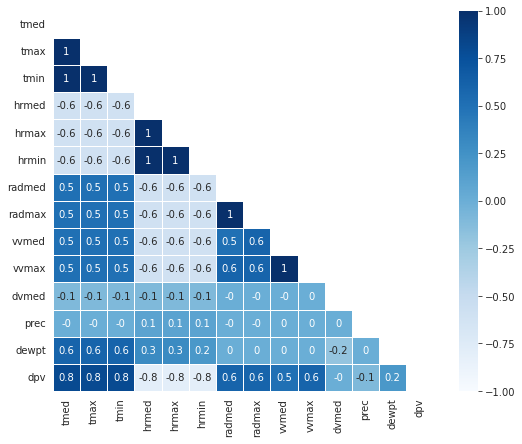

In [102]:
corr=MU62_dm.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr.round(1), 
                     xticklabels=corr, yticklabels=corr,
                     mask=mask, vmin=-1, vmax=1, square=True,
                     annot = True, linewidths=.5, cmap="Blues")

Hay algunas de las variables que están totalmente correlacionadas y por tanto podemos quedarnos sólo con algunas de ellas. En concreto, de 'tmax', 'tmin' y 'tmed' nos quedaremos con 'tmed', de 'hrmax','hrmin' y 'hrmed' con 'hrmed',  de 'radmed' y 'radmax' con 'redmed' y de 'vvmed' y 'vvmax' con 'vvmed'.

In [16]:
weather = pd.read_csv("MU62_dm.txt", sep = ";")
data = MU62_dm[['fecha' ,'hora', 'tmed', 'hrmed', 'radmed', 'vvmed', 'dvmed', 'prec', 'dewpt', 'dpv']]
#data = pd.read_csv('data-meteo.csv', sep=';') 

In [17]:
def data_meteo(datos, interval):
    weather = datos              #Datos meteorológicos
    pd.options.mode.chained_assignment = None #Para evitar falso positivo de SettingWithCopyWarning
    weather['Fecha']= pd.to_datetime(weather.fecha+ ' '+weather.hora, format='%d/%m/%y %H:%M:%S')
    weather = weather.drop(columns=['fecha','hora'])
    weather['Fecha'] = pd.to_datetime(weather['Fecha'], utc = 'True')
    mask = (weather['Fecha'] >= '2021-01-01 00:00:00') & (weather['Fecha'] <= '2021-12-18 00:00:01')
    weather = weather.loc[mask]
    weather = weather.fillna(method="ffill")
    weather = weather.resample(res_time, on='Fecha').mean().round(1)
    weather = weather.fillna(method="ffill")
    weather.to_csv('data-meteo-' + interval + '.csv', sep=";")

In [18]:
res_time= '120T'

In [19]:
data_meteo(data, res_time)

In [269]:
df = pd.read_csv('data-meteo-' + res_time + '.csv', sep=";")
df

,Fecha,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
0,2021-01-01 00:10:00+00:00,3.6,65.4,0.0,0.6,180.7,0.0,-2.3,0.3
1,2021-01-01 00:20:00+00:00,3.4,64.0,0.0,0.2,191.3,0.0,-2.7,0.3
2,2021-01-01 00:30:00+00:00,3.5,63.9,0.0,0.2,251.2,0.0,-2.7,0.3
3,2021-01-01 00:40:00+00:00,3.3,63.2,0.0,0.1,241.2,0.0,-3.0,0.3
4,2021-01-01 00:50:00+00:00,2.9,65.5,0.0,0.3,175.5,0.0,-2.9,0.3
...,...,...,...,...,...,...,...,...,...
50538,2021-12-17 23:10:00+00:00,12.1,74.1,0.0,0.0,91.0,0.0,7.6,0.4
50539,2021-12-17 23:20:00+00:00,12.1,74.3,0.0,0.0,36.9,0.0,7.7,0.4
50540,2021-12-17 23:30:00+00:00,12.0,75.3,0.0,0.0,0.0,0.0,7.8,0.3
50541,2021-12-17 23:40:00+00:00,12.1,76.1,0.0,0.0,0.0,0.0,8.0,0.3


In [159]:
#Nulos entre:
#50625 - 2021-12-18 13:40:00+00:00
#53855 - 2022-01-10 00:00:00+00:00

,Fecha,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
53850,2022-01-09 23:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53851,2022-01-09 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53852,2022-01-09 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53853,2022-01-09 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53854,2022-01-09 23:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53855,2022-01-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53856,2022-01-10 00:10:00+00:00,16.6,46.8,0.0,8.3,284.0,0.0,5.2,1.0
53857,2022-01-10 00:20:00+00:00,16.6,47.3,0.0,7.3,282.6,0.0,5.3,1.0
53858,2022-01-10 00:30:00+00:00,16.5,47.8,0.0,6.8,283.4,0.0,5.4,1.0
53859,2022-01-10 00:40:00+00:00,16.5,48.0,0.0,6.6,284.0,0.0,5.5,1.0


## relations-hvac.csv

Nos da las relaciones entre el id del hvac y la habitación y edificio al que pertenece

- ID: Identificador del hvac
- desc: descripción del dispositivo
- block: edificio
- room: habitación

In [27]:
relations_hvac = pd.read_csv("relations-hvac.csv", sep=",")
relations_hvac.head(3)

,ID,desc,block,room
0,335545147,Unidad Toshiba VRF Pleiades (02.ED136.B1.0.058),B,B1.0.058
1,335545149,Unidad Toshiba VRF Pleiades (02.ED136.B1.0.058),B,B1.0.058
2,335545143,Unidad Toshiba VRF Pleiades (02.ED136.B1.0.059),B,B1.0.059


Es importante darnos cuenta de que algunas de las habitaciones tienen más de un aparato:

In [28]:
print(len(relations_hvac['room'].unique()))
print(len(relations_hvac['ID'].unique()))

79
86


In [33]:
# Para obtener los ids de los aparados correspondientes a cada edificio
#df = relations_hvac.where(relations_hvac['block']=='A').dropna()
#df['ID'].astype(int).unique()

In [32]:
# Para ver las habitaciones con hvac de cada edificio 
#df = relations_hvac.where(relations_hvac['block']=='C').dropna()
#df['room'].unique()

In [39]:
rooms_hvac_A = ['B1.0.000', 'B1.1.010', 'B1.1.009', 'B1.1.023', 'B1.1.024', 'B1.1.025', 'B1.1.008', 'B1.1.007', 'B1.1.006', 'B1.1.026', 'B1.1.027', 'B1.2.008', 'B1.2.008.1', 'B1.2.007.1', 'B1.2.024', 'B1.2.025', 'B1.2.026.1', 'B1.2.026', 'B1.2.026.2', 'B1.2.007', 'B1.2.006', 'B1.2.027', 'B1.2.027.2', 'B1.2.027.1', 'B1.2.028.1', 'B1.2.028', 'B1.3.010', 'B1.3.009', 'B1.3.008', 'B1.3.014', 'B1.3.013', 'B1.3.007', 'B1.3.006', 'B1.3.015', 'B1.3.018.1', 'B1.3.018.3', 'B1.3.018.2', 'B1.4.010', 'B1.4.009', 'B1.4.008', 'B1.4.007', 'B1.4.013', 'B1.4.014', 'B1.4.015', 'B1.4.006', 'B1.4.016', 'B1.4.017']
rooms_hvac_B = ['B1.0.058', 'B1.0.059', 'B1.0.047', 'B1.0.051', 'B1.0.050', 'B1.0.051.1', 'B1.0.052', 'B1.0.055', 'B1.1.014', 'B1.1.015', 'B1.1.016', 'B1.1.017', 'B1.2.019', 'B1.2.020', 'B1.2.013', 'B1.2.014', 'B1.2.015', 'B1.2.016']
rooms_hvac_C = ['B1.1.049', 'B1.1.047', 'B1.1.046', 'B1.1.045', 'B1.1.044', 'B1.1.043', 'B1.1.042', 'B1.1.041.3', 'B1.1.041.2', 'B1.1.041.1', 'B1.0.026', 'B1.0.025', 'B1.0.011', 'B1.0.024']

## relations-sensor.csv

Mismo que lo anterior pero con los sensores de temperatura en las habitaciones

In [34]:
relations_sensor = pd.read_csv("relations-sensor.csv", sep = ";")
relations_sensor.head(3)

,ID,desc,block,room
0,335544455,Sensor temperatura sala 4.2,A,B1.4.009
1,335544458,Sensor temperatura sala 4.3,A,B1.4.008
2,335544461,Sensor temperatura sala 4.4,A,B1.4.007


Igual que antes, también hay habitaciones con más de un sensor

In [35]:
print(len(relations_sensor['room'].unique()))
print(len(relations_sensor['ID'].unique()))

61
90


In [ ]:
#Para obtener los ids de los aparados correspondientes a cada edificio
#df = relations_sensor.where(relations_sensor['block']=='A').dropna()
#df['ID'].astype(int).unique()

In [ ]:
# Para ver las habitaciones con sensor de cada edificio 
#df = relations_sensor.where(relations_sensor['block']=='C').dropna()
#df['room'].unique()

In [38]:
rooms_sensor_A = ['B1.4.009', 'B1.4.008', 'B1.4.007', 'B1.4.004', 'B1.4.013', 'B1.4.014', 'B1.4.015', 'B1.4.006', 'B1.4.016', 'B1.4.017', 'B1.3.010', 'B1.3.009', 'B1.3.014', 'B1.3.008', 'B1.3.007', 'B1.3.006', 'B1.3.018.3', 'B1.3.018.2', 'B1.3.018.1', 'B1.3.004', 'B1.2.008', 'B1.2.026', 'B1.2.007', 'B1.2.006', 'B1.2.027', 'B1.2.027.2', 'B1.2.004', 'B1.2.028', 'B1.1.010', 'B1.1.009', 'B1.1.023', 'B1.1.024', 'B1.1.025', 'B1.1.005', 'B1.1.008', 'B1.1.007', 'B1.1.006', 'B1.1.026', 'B1.1.027', 'B1.4.010']
rooms_sensor_B = ['B1.2.020', 'B1.2.013', 'B1.2.014', 'B1.2.015', 'B1.2.016', 'B1.1.021', 'B1.1.014', 'B1.1.015', 'B1.1.016', 'B1.1.017', 'B1.1.013', 'B1.0.059', 'B1.1.020', 'B1.2.012', 'B1.2.019', 'B1.1.016 ', 'B1.2.014 ']
rooms_sensor_C = ['B1.0.026', 'B1.0.025', 'B1.0.024', 'B1.1.029']

Buscamos la intersección entre los conjuntos de habitaciones con hvac y con sensor, ya que si no hay información de uno de los dos no nos servirán:

In [37]:
rooms_A = list(set(rooms_hvac_A).intersection(rooms_sensor_A))
rooms_B = list(set(rooms_hvac_B).intersection(rooms_sensor_B))
rooms_C = list(set(rooms_hvac_C).intersection(rooms_sensor_C))

In [26]:
#pd.read_csv('data-room-10T-C.csv', sep=';').head(2)

## data-room-10T-_.csv

- room
- block
- Id del sensor y hvac
- dif: diferencia de consumo entre fecha y fecha anterior, agregada para cada edificio
- cons_total: consumo acumulado entre fecha y fecha anterior
- V4 (ON/OFF), V5(modo de funcionamiento), V12(setpoint)
- V2 (temperatura sala según sensor)
- Datos meteorológicos

Se obtiene de cons_.csv, temp_sensor_.csv, data-meteo.csv, relations-sensor.csv, relations-hvac, data-hvac.csv, data-sensor.csv

In [2]:
ids_hvac_A = [335545141, 335545231, 335545233, 335545239, 335545235, 335545237, 335545221, 335545223, 335545225, 335545227, 335545229, 335545245, 335545241, 335545243, 335545251, 335545253, 335545255, 335545249, 335545247, 335545257, 335545259, 335545263, 335545261, 335545265, 335545267, 335545269, 335545277, 335545279, 335545281, 335545271, 335545275, 335545273, 335545283, 335545285, 335545287, 335545293, 335545289, 335545291, 335545301, 335545295, 335545297, 335545299, 335545303, 335545305, 335545307, 335545309, 335545311, 335545313, 335545315]
ids_hvac_B = [335545147, 335545149, 335545143, 335545163, 335545165, 335545161, 335545155, 335545153, 335545159, 335545151, 335545157, 335545203, 335545205, 335545201, 335545197, 335545199, 335545217, 335545219, 335545213, 335545215, 335545207, 335545209, 335545211]
ids_hvac_C = [335545193, 335545191, 335545189, 335545187, 335545183, 335545177, 335545181, 335545179, 335545185, 335545167, 335545169, 335545171, 335545175, 335545173]
ids_sensor_A = [335544455, 335544458, 335544461, 335544472, 335544479, 335544488, 335544491, 335544499, 335544506, 335544517, 335544522, 335544529, 335544532, 335544542, 335544547, 335544554, 335544557, 335544563, 335544569, 335544575, 335544605, 335544613, 335544628, 335544639, 335544648, 335544655, 335544660, 335544672, 335544736, 335544739, 335544747, 335544750, 335544764, 335544770, 335544790, 335544791, 335544792, 335544811, 335544812, 335544979, 335545134, 335547743, 335547759, 335547765, 335547778, 335547785, 335547798, 335547804, 335547817]
ids_sensor_B = [335544685, 335544692, 335544699, 335544720, 335544721, 335544823,335544830, 335544838, 335544857, 335544858, 335544863, 335544977, 335545020, 335545055, 335545056, 335545087, 335545091, 335547856, 335547861, 335547871, 335547879, 335547886, 335547887, 335547901, 335547902, 335547903, 335547925, 335547926, 335547940, 335547950, 335547951, 335547965, 335547966, 335547967, 335548038]
ids_sensor_C = [335544931, 335544934, 335544941, 335544948, 335545128, 335545129]

In [19]:
def data_room(edificio, interval, ids_hvac, ids_sensor):
    cons = pd.read_csv("cons" + edificio + "-" + interval + ".csv", sep= ";")
    #temp_sensor = pd.read_csv("temp-sensor" + edificio + "-" + interval + ".csv", sep=";")                
    weather = pd.read_csv('data-meteo-' + res_time + '.csv', sep=';')               
    mask = (weather['Fecha'] >= '2021-01-01 00:00:01') & (weather['Fecha'] <= '2021-12-18 00:00:01')
    weather = weather.loc[mask]
    weather = weather.fillna(method="ffill")
    relations_sensor = pd.read_csv("relations-sensor.csv", sep = ";") #Relaciones entre edificios, sensores y habitación
    relations_hvac = pd.read_csv("relations-hvac.csv")                #Relaciones entre edificios, aparatos y habitación

    hvac = pd.read_csv("data-hvac.csv")
    data = hvac
    ids = ids_hvac
    mask = data['IDdispositivo'].isin(ids)
    df = data.loc[mask]
    #Ordenamos por ID y fecha para tener todos los registros de cada hvac seguidos y además ordenaods por fecha
    #Después cambiamos los 0's de V12 por nulos y hacemos foward fill para reemplazarlo por el último valor no nulo
    df = df.sort_values(by=['IDdispositivo', 'Fecha'], ascending=True)
    mask = (df['V12']<=0) | (df['V12']>60)
    df.loc[mask, 'V12'] = np.nan
    df['V12'] = df['V12'].fillna(method="ffill")
    mask = (df['V4']==0)
    df.loc[mask, 'V26'] = 0
    df = df[["IDdispositivo", "Fecha", "V4", "V5", "V12", "V26"]]

    df1 = pd.merge(df, relations_hvac, left_on="IDdispositivo", right_on="ID")
    df1 = df1[["Fecha","IDdispositivo", "block", "room","V4", "V5", "V12", "V26"]]
    df1 = df1.set_index(['Fecha'])
    df1.index = pd.to_datetime(df1.index, utc = True)

    df1_1 = df1.groupby(['IDdispositivo','block', 'room']).resample(interval)['V12'].mean().to_frame().reset_index()
    df1_1['V12'] = df1_1['V12'].fillna(method="ffill")

    df1_2 = df1.groupby(['IDdispositivo','block', 'room']).resample(interval)['V5'].median().to_frame().reset_index()
    df1_2['V5'] = df1_2['V5'].fillna(method="ffill")

    df1_3 = df1.groupby(['IDdispositivo','block', 'room']).resample(interval)['V4'].mean().round().to_frame().reset_index()
    df1_3['V4'] = df1_3['V4'].fillna(method="ffill")


    df1_4 = df1.groupby(['IDdispositivo','block', 'room']).resample(interval)['V26'].mean().round(1).to_frame().reset_index()
    df1_4['V26'] = df1_4['V26'].fillna(method="ffill")

    df1 = pd.merge(df1_1,df1_2)
    df1 = pd.merge(df1,df1_3)
    df1 = pd.merge(df1,df1_4)
    df1 = df1.rename(columns={'IDdispositivo': 'IDhvac'})

    temp_sensor = pd.read_csv('data-sensor.csv', sep=';')
    #Ids de los sensores del edificio A
    ids = ids_sensor
    mask = temp_sensor['IDdispositivo'].isin(ids)
    temp_sensor = temp_sensor.loc[mask]
    temp_sensor = temp_sensor[["IDdispositivo", "Fecha", "V2"]]

    df2 = pd.merge(temp_sensor, relations_sensor, left_on="IDdispositivo", right_on="ID")
    df2 = df2.set_index('Fecha')
    df2.index = pd.to_datetime(df2.index, utc = True)
    df2 = df2[["IDdispositivo", "V2", "block", "room"]]
    df2 = df2.sort_values(by=['IDdispositivo'], ascending=True)
    #Ponemos valores extremos o erróneos como nulos y los reescribimos con el un valor anterior válido
    mask = (df2['V2']<15) | (df2['V2']>40)
    df2.loc[mask, 'V2'] = np.nan
    df2['V2'] = df2['V2'].fillna(method="ffill")

    df2 = df2.sort_values(by=['Fecha'], ascending=False)
    #df2 = df2.set_index('Fecha')
    #df2.index = pd.to_datetime(df2.index, utc = True)

    #Remuestreo en V2 haciendo media de temperaturas y de nuevo reescribimos nulos
    df2 = df2.groupby(['IDdispositivo','block', 'room']).resample(interval)['V2'].mean().to_frame()
    df2['V2'] = df2['V2'].fillna(method="ffill")
    df2 = df2.reset_index()
    df2 = df2.rename(columns={'IDdispositivo': 'IDsensor'})
    
    cons['Fecha'] =  pd.to_datetime(cons['Fecha'], utc = True)
    weather['Fecha'] =  pd.to_datetime(weather['Fecha'], utc = True)
    
    merge1 = pd.merge(cons, df1, how="inner")
    merge2 = pd.merge(merge1, df2, how="inner", on = ["Fecha",'block','room'])
    merge2['Fecha'] =  pd.to_datetime(merge2['Fecha'], utc = True)
    merge3 = pd.merge(merge2, weather, how="inner")
    merge3 = merge3.round({'dif_cons': 2,'cons_total': 2, 'V2': 1})

    merge3['V5'] = merge3['V5'].astype(int)
    mask = (merge3['V4']==0)
    merge3.loc[mask, 'V5'] = 0
    merge3 = pd.concat([merge3, pd.get_dummies(merge3.V5, prefix='V5')], axis=1).drop(columns=['V5'])

    #Añadimos otra variable que divida el día en tres partes (mañana/tarde/noche) y la ponemos también como dummy
    merge3['Fecha'] =  pd.to_datetime(merge3['Fecha'], utc = True)
    def hora_(Hora):
        if Hora in range(6,14): return 1
        if Hora in range(14,22): return 2
        if Hora in [22,23,0,1,2,3,4,5]: return 3
    merge3['Hora'] = merge3['Fecha'].dt.hour
    merge3['Hora'] = merge3['Hora'].apply(hora_).astype(int)
    merge3 = pd.concat([merge3, pd.get_dummies(merge3.Hora, prefix='Hora')], axis=1).drop(columns=['Hora'])
    
    def season(Mes):
        if Mes in range(1,4): return 1
        if Mes in range(4,7): return 2
        if Mes in range(7,10): return 3
        if Mes in range(10,13): return 4
    merge3['Season'] = merge3['Fecha'].dt.month
    merge3['Season'] = merge3['Season'].apply(season).astype(int)
    merge3 = pd.concat([merge3, pd.get_dummies(merge3.Season, prefix='Season')], axis=1).drop(columns=['Season'])

    #Fijamos el límite de la fecha hasta cuando tenemos datos meteorológicos
    #mask = (merge3['Fecha'] >= '2021-01-01 00:00:00') & (merge3['Fecha'] <= '2021-12-18 00:00:01')
    #merge3 = merge3.loc[mask]
    merge3.to_csv('data-room' + edificio + '-' + interval + '.csv', sep=";", index=False)

In [3]:
edificio = 'C'
res_time = '10T'

In [29]:
data_room(edificio, res_time, ids_hvac_C, ids_sensor_C)

In [4]:
df = pd.read_csv('data-roomA-10T.csv', sep=';')

In [5]:
df

,Fecha,dif_cons,cons_total,IDhvac,block,room,V12,V4,V26,IDsensor,...,V5_0,V5_1,V5_2,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:10:00+00:00,0.23,1.55,335545221,A,B1.1.008,21.0,0.0,0.0,335544790,...,1,0,0,0,0,1,1,0,0,0
1,2021-01-01 00:10:00+00:00,0.23,1.55,335545223,A,B1.1.007,21.0,0.0,0.0,335544791,...,1,0,0,0,0,1,1,0,0,0
2,2021-01-01 00:10:00+00:00,0.23,1.55,335545225,A,B1.1.006,25.0,0.0,0.0,335544792,...,1,0,0,0,0,1,1,0,0,0
3,2021-01-01 00:10:00+00:00,0.23,1.55,335545227,A,B1.1.026,24.0,0.0,0.0,335544811,...,1,0,0,0,0,1,1,0,0,0
4,2021-01-01 00:10:00+00:00,0.23,1.55,335545229,A,B1.1.027,24.0,0.0,0.0,335544812,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021715,2021-12-17 23:50:00+00:00,0.16,41249.75,335545309,A,B1.4.006,21.0,0.0,0.0,335544979,...,1,0,0,0,0,1,0,0,0,1
2021716,2021-12-17 23:50:00+00:00,0.16,41249.75,335545311,A,B1.4.006,24.0,0.0,0.0,335544499,...,1,0,0,0,0,1,0,0,0,1
2021717,2021-12-17 23:50:00+00:00,0.16,41249.75,335545311,A,B1.4.006,24.0,0.0,0.0,335544979,...,1,0,0,0,0,1,0,0,0,1
2021718,2021-12-17 23:50:00+00:00,0.16,41249.75,335545313,A,B1.4.016,23.0,0.0,0.0,335544506,...,1,0,0,0,0,1,0,0,0,1


Juntamos todo en un mismo csv

In [191]:
#agg = '10T'

In [6]:
A = pd.read_csv('data-roomA-' + res_time + '.csv', sep=";")
B = pd.read_csv('data-roomB-' + res_time + '.csv', sep=";")
C = pd.read_csv('data-roomC-' + res_time + '.csv', sep=";")

In [31]:
A.head(2)

,Fecha,dif_cons,cons_total,IDhvac,block,room,V12,V4,V26,IDsensor,...,V5_0,V5_1,V5_2,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:10:00+00:00,0.23,1.55,335545221,A,B1.1.008,21.0,0.0,0.0,335544790,...,1,0,0,0,0,1,1,0,0,0
1,2021-01-01 00:10:00+00:00,0.23,1.55,335545223,A,B1.1.007,21.0,0.0,0.0,335544791,...,1,0,0,0,0,1,1,0,0,0


In [10]:
A.columns

Index(['Fecha', 'dif_cons', 'cons_total', 'IDhvac', 'block', 'room', 'V12',
       'V4', 'V26', 'IDsensor', 'V2', 'tmed', 'hrmed', 'radmed', 'vvmed',
       'dvmed', 'prec', 'dewpt', 'dpv', 'V5_0', 'V5_1', 'V5_2', 'Hora_1',
       'Hora_2', 'Hora_3', 'Season_1', 'Season_2', 'Season_3', 'Season_4'],
      dtype='object')

In [192]:
#A = pd.read_csv('data-room-' +agg+'-A.csv', sep=";")
#B = pd.read_csv('data-room-' +agg+'-B.csv', sep=";")
#C = pd.read_csv('data-room-' +agg+'-C.csv', sep=";")

In [132]:
A.dtypes

Fecha          object
dif_cons      float64
cons_total    float64
IDhvac          int64
block          object
room           object
V12           float64
V4            float64
V26           float64
IDsensor        int64
V2            float64
tmed          float64
hrmed         float64
radmed        float64
vvmed         float64
dvmed         float64
prec          float64
dewpt         float64
dpv           float64
V5_0            int64
V5_1            int64
V5_2            int64
Hora_1          int64
Hora_2          int64
Hora_3          int64
dtype: object

In [32]:
cols = [0,5,4,3,9,1,2,10,6,7,8,19,20,21]+list(range(11,18))+[22,23,24,25,26,27,28] #Para reordenar
df = pd.concat([A,B,C]).sort_values(by=['Fecha'])
df = df.iloc[:,cols]
print(df.shape)
df.head(3)

(3083123, 28)


,Fecha,room,block,IDhvac,IDsensor,dif_cons,cons_total,V2,V12,V4,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:10:00+00:00,B1.1.008,A,335545221,335544790,0.23,1.55,19.9,21.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0
33,2021-01-01 00:10:00+00:00,B1.4.015,A,335545307,335544491,0.23,1.55,25.5,22.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0
34,2021-01-01 00:10:00+00:00,B1.4.006,A,335545309,335544499,0.23,1.55,22.9,21.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0


In [33]:
df.isnull().sum()

Fecha         0
room          0
block         0
IDhvac        0
IDsensor      0
dif_cons      0
cons_total    0
V2            0
V12           0
V4            0
V26           0
V5_0          0
V5_1          0
V5_2          0
tmed          0
hrmed         0
radmed        0
vvmed         0
dvmed         0
prec          0
dewpt         0
Hora_1        0
Hora_2        0
Hora_3        0
Season_1      0
Season_2      0
Season_3      0
Season_4      0
dtype: int64

In [34]:
df.to_csv('data-room-' + res_time + '.csv', sep=";", index=False)

In [50]:
pd.read_csv('data-room-10T.csv', sep=";", index_col=0).head(3)

,room,block,IDhvac,IDsensor,dif_cons,cons_total,V2,V12,V4,V26,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:10:00+00:00,B1.1.008,A,335545221,335544790,0.23,1.55,19.9,21.0,0.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0
2021-01-01 00:10:00+00:00,B1.4.015,A,335545307,335544491,0.23,1.55,25.5,22.0,0.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0
2021-01-01 00:10:00+00:00,B1.4.006,A,335545309,335544499,0.23,1.55,22.9,21.0,0.0,0.0,...,180.7,0.0,-2.3,0,0,1,1,0,0,0


**Fichero data-room-10T-all.csv**

- Creamos un dataframe, que llamamos df_time, cuyas columnas son una fecha, con entradas cada 10 minutos desde el 2021-01-01 0:00:00 hasta 2021-12-18 00:00:00+00:00, usando un range con el módulo datetime y después reperición con np.repeat; las 50 habitaciones en las que hay datos en esas fechas, de forma que tenemos cada fecha 50 veces, una por habitación; y el edificio correspondiente a cada habitación, para al hacer el merge, poder conservar esa información.


- Partiendo de data-room-10T.csv, ponemos el tipo de datos de los ids del sensor y hvac como string (podríamos quitarlos directamente), ya que no queremos que con esos enteros se haga una media al hacer groupby().


- Hacemos groupby por Fecha, Block y Room, y después ponemos la fecha como string para que sea el mismo tipo de dato que la fecha del df_time.


- Hacemos el merge como left join del df_time sobre los datos agrupados con las columnas de Fecha, Room y Block. Esto no da un dataframe con una 50 entradas para una fecha, cada 10 minutos, durante cerca de 90 días, de forma que para las habitaciones que en alguna fecha no había alguno de los datos (temp, on/off, etc) tendremos valores nulos.

In [36]:
import datetime
import numpy as np

In [40]:
rooms_A = list(set(rooms_hvac_A).intersection(rooms_sensor_A))
rooms_B = list(set(rooms_hvac_B).intersection(rooms_sensor_B))
rooms_C = list(set(rooms_hvac_C).intersection(rooms_sensor_C))

In [42]:
rooms = rooms_A + rooms_B + rooms_C

In [43]:
len(rooms)

50

In [51]:
dti = pd.date_range(start="2021-01-01 00:10:00", end="2021-12-17 23:50:00", freq="10T")
dti = dti.tz_localize("UTC")
df_time = pd.DataFrame()
df_time['Fecha'] = np.repeat(dti.astype(str),50)
rooms = rooms
df_time['room'] = rooms*len(dti)
df_time['block'] = (list(np.repeat('A',36)) + list(np.repeat('B',11)) + list(np.repeat('C',3)))*len(dti)
print(df_time.shape)
df_time.head(3)

(2527150, 3)


,Fecha,room,block
0,2021-01-01 00:10:00+00:00,B1.1.010,A
1,2021-01-01 00:10:00+00:00,B1.3.010,A
2,2021-01-01 00:10:00+00:00,B1.1.008,A


In [52]:
df = pd.read_csv('data-room-10T.csv', sep=";")
df = df.astype({'IDhvac': 'string', 'IDsensor': 'string'})
df = df.groupby(['Fecha', 'room', 'block']).mean().reset_index()
df = df.astype({'Fecha': 'string'})
print(df.shape)
df.head(3)

(2527150, 26)


,Fecha,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:10:00+00:00,B1.0.024,C,0.11,0.79,23.0,23.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2021-01-01 00:10:00+00:00,B1.0.025,C,0.11,0.79,22.6,23.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2021-01-01 00:10:00+00:00,B1.0.026,C,0.11,0.79,21.7,23.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [53]:
merge1 = pd.merge(df_time, df, how = 'left', on=['Fecha','room', 'block']).round({'dif_cons': 2,'cons_total': 2, 'V2': 1, 'V4':0})

In [54]:
merge1

,Fecha,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
0,2021-01-01 00:10:00+00:00,B1.1.010,A,0.23,1.55,20.0,21.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2021-01-01 00:10:00+00:00,B1.3.010,A,0.23,1.55,21.1,24.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2021-01-01 00:10:00+00:00,B1.1.008,A,0.23,1.55,19.9,21.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,2021-01-01 00:10:00+00:00,B1.1.024,A,0.23,1.55,24.3,24.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2021-01-01 00:10:00+00:00,B1.4.007,A,0.23,1.55,23.2,25.0,0.0,0.0,1.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527145,2021-12-17 23:50:00+00:00,B1.1.017,B,0.52,22403.96,22.7,24.5,0.0,0.0,1.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2527146,2021-12-17 23:50:00+00:00,B1.2.016,B,0.52,22403.96,22.3,25.0,0.0,0.0,1.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2527147,2021-12-17 23:50:00+00:00,B1.0.026,C,0.09,41624.85,24.0,23.5,0.0,0.0,1.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2527148,2021-12-17 23:50:00+00:00,B1.0.024,C,0.09,41624.85,24.3,23.0,0.0,0.0,1.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [55]:
merge1.loc[merge1['dif_cons'].isnull()]

,Fecha,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4


In [56]:
merge1.isnull().sum()

Fecha         0
room          0
block         0
dif_cons      0
cons_total    0
V2            0
V12           0
V4            0
V26           0
V5_0          0
V5_1          0
V5_2          0
tmed          0
hrmed         0
radmed        0
vvmed         0
dvmed         0
prec          0
dewpt         0
Hora_1        0
Hora_2        0
Hora_3        0
Season_1      0
Season_2      0
Season_3      0
Season_4      0
dtype: int64

In [57]:
merge1.to_csv('data-room-10T-all.csv', sep=";", index = False)

In [11]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";")
print(datos.shape)

(2527150, 26)


In [12]:
datos.columns

Index(['Fecha', 'room', 'block', 'dif_cons', 'cons_total', 'V2', 'V12', 'V4',
       'V26', 'V5_0', 'V5_1', 'V5_2', 'tmed', 'hrmed', 'radmed', 'vvmed',
       'dvmed', 'prec', 'dewpt', 'Hora_1', 'Hora_2', 'Hora_3', 'Season_1',
       'Season_2', 'Season_3', 'Season_4'],
      dtype='object')

In [59]:
datos.iloc[805012:805050,:]

,Fecha,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
805012,2021-04-22 19:30:00+00:00,B1.3.018.3,A,0.83,7355.25,26.1,25.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805013,2021-04-22 19:30:00+00:00,B1.1.009,A,0.83,7355.25,23.7,21.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805014,2021-04-22 19:30:00+00:00,B1.2.008,A,0.83,7355.25,24.6,24.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805015,2021-04-22 19:30:00+00:00,B1.2.026,A,0.83,7355.25,26.1,21.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805016,2021-04-22 19:30:00+00:00,B1.1.026,A,0.83,7355.25,25.8,21.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805017,2021-04-22 19:30:00+00:00,B1.3.008,A,0.83,7355.25,29.2,29.0,1.0,2.0,0.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805018,2021-04-22 19:30:00+00:00,B1.3.018.1,A,0.83,7355.25,24.4,21.0,1.0,2.0,0.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805019,2021-04-22 19:30:00+00:00,B1.1.006,A,0.83,7355.25,24.7,29.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805020,2021-04-22 19:30:00+00:00,B1.2.027,A,0.83,7355.25,27.0,23.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
805021,2021-04-22 19:30:00+00:00,B1.1.023,A,0.83,7355.25,25.1,24.0,0.0,0.0,1.0,...,59.0,0.0,10.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [149]:
datos.iloc[0:50,:]

,Fecha,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,...,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3
0,2021-01-01 00:00:00+00:00,B1.3.014,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 00:00:00+00:00,B1.1.024,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 00:00:00+00:00,B1.3.008,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 00:00:00+00:00,B1.2.026,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 00:00:00+00:00,B1.4.014,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-01-01 00:00:00+00:00,B1.2.008,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-01-01 00:00:00+00:00,B1.2.027,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-01-01 00:00:00+00:00,B1.4.015,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-01-01 00:00:00+00:00,B1.2.027.2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-01-01 00:00:00+00:00,B1.1.009,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
rooms_B

['B1.2.020',
 'B1.1.014',
 'B1.2.013',
 'B1.2.016',
 'B1.1.015',
 'B1.1.017',
 'B1.2.015',
 'B1.2.019',
 'B1.2.014',
 'B1.0.059',
 'B1.1.016']

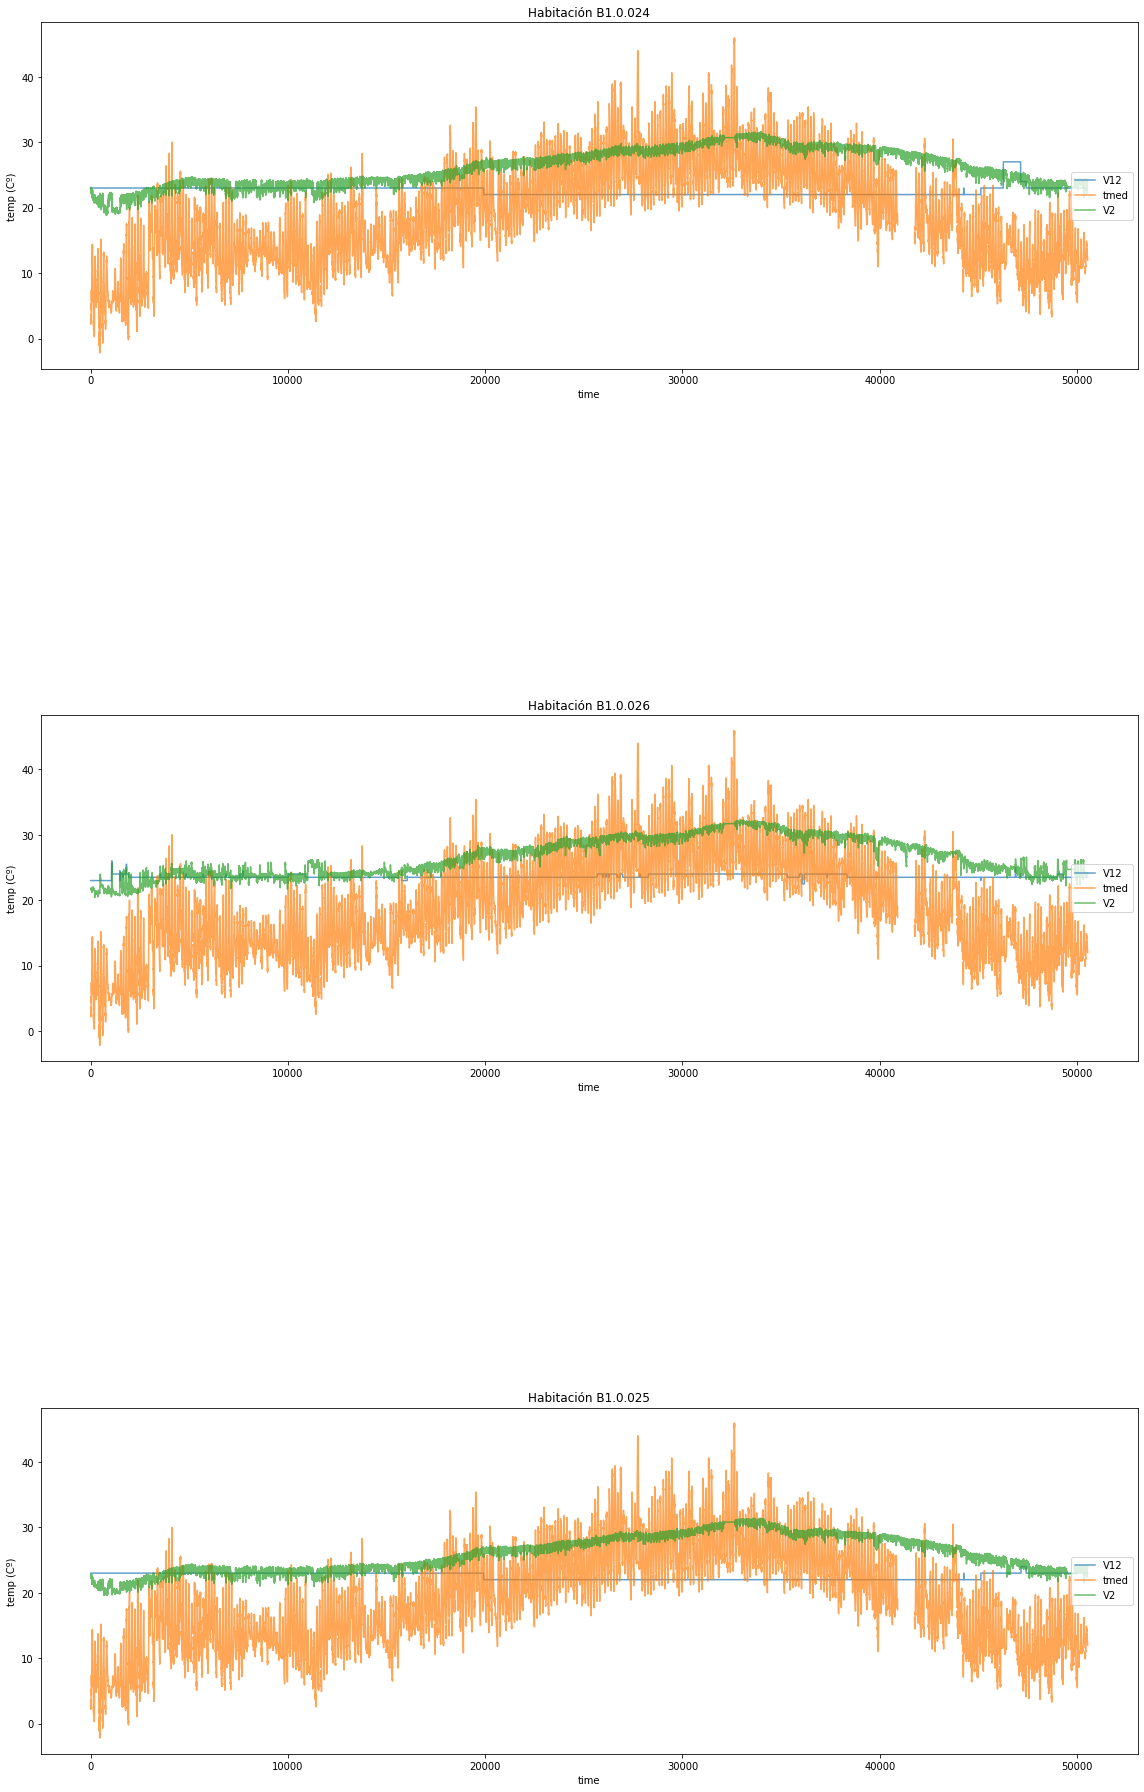

In [151]:
#EDIFICIO B
rooms = rooms_C
#Hacemos un plot por cada habitación
fig, axes = plt.subplots(figsize=(16,25), nrows = len(rooms), ncols = 1, sharex=False, sharey= False)

for count,room in enumerate(rooms):
    mask = datos['room'].isin([room])
    datos_room = datos.loc[mask]
    datos_room[['V12', 'tmed','V2']].plot(ax=axes[count], use_index = False, alpha =0.7) #Si ponemos el index de fecha ocupa mucho y no se lee bien
    axes[count].set_title('Habitación ' + room)
    axes[count].set_ylabel('temp (Cº)')
    axes[count].set_xlabel('time')
    axes[count].legend(loc="right")
fig.tight_layout()
#Para rotar los labels del eje x si lo ponemos con fecha, ya que sin rotar solapan
#for ax in fig.axes:
#    plt.sca(ax)
#    plt.xticks(rotation=0)
#Para aumentar el espaciado vertical entre gráficas
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

Las habitaciones tipo B1.2.xxx tienen valores ausentes todas en el mismo período, e igual ocurre con las B1.1.xxx, con alguna excepción en ambos casos.

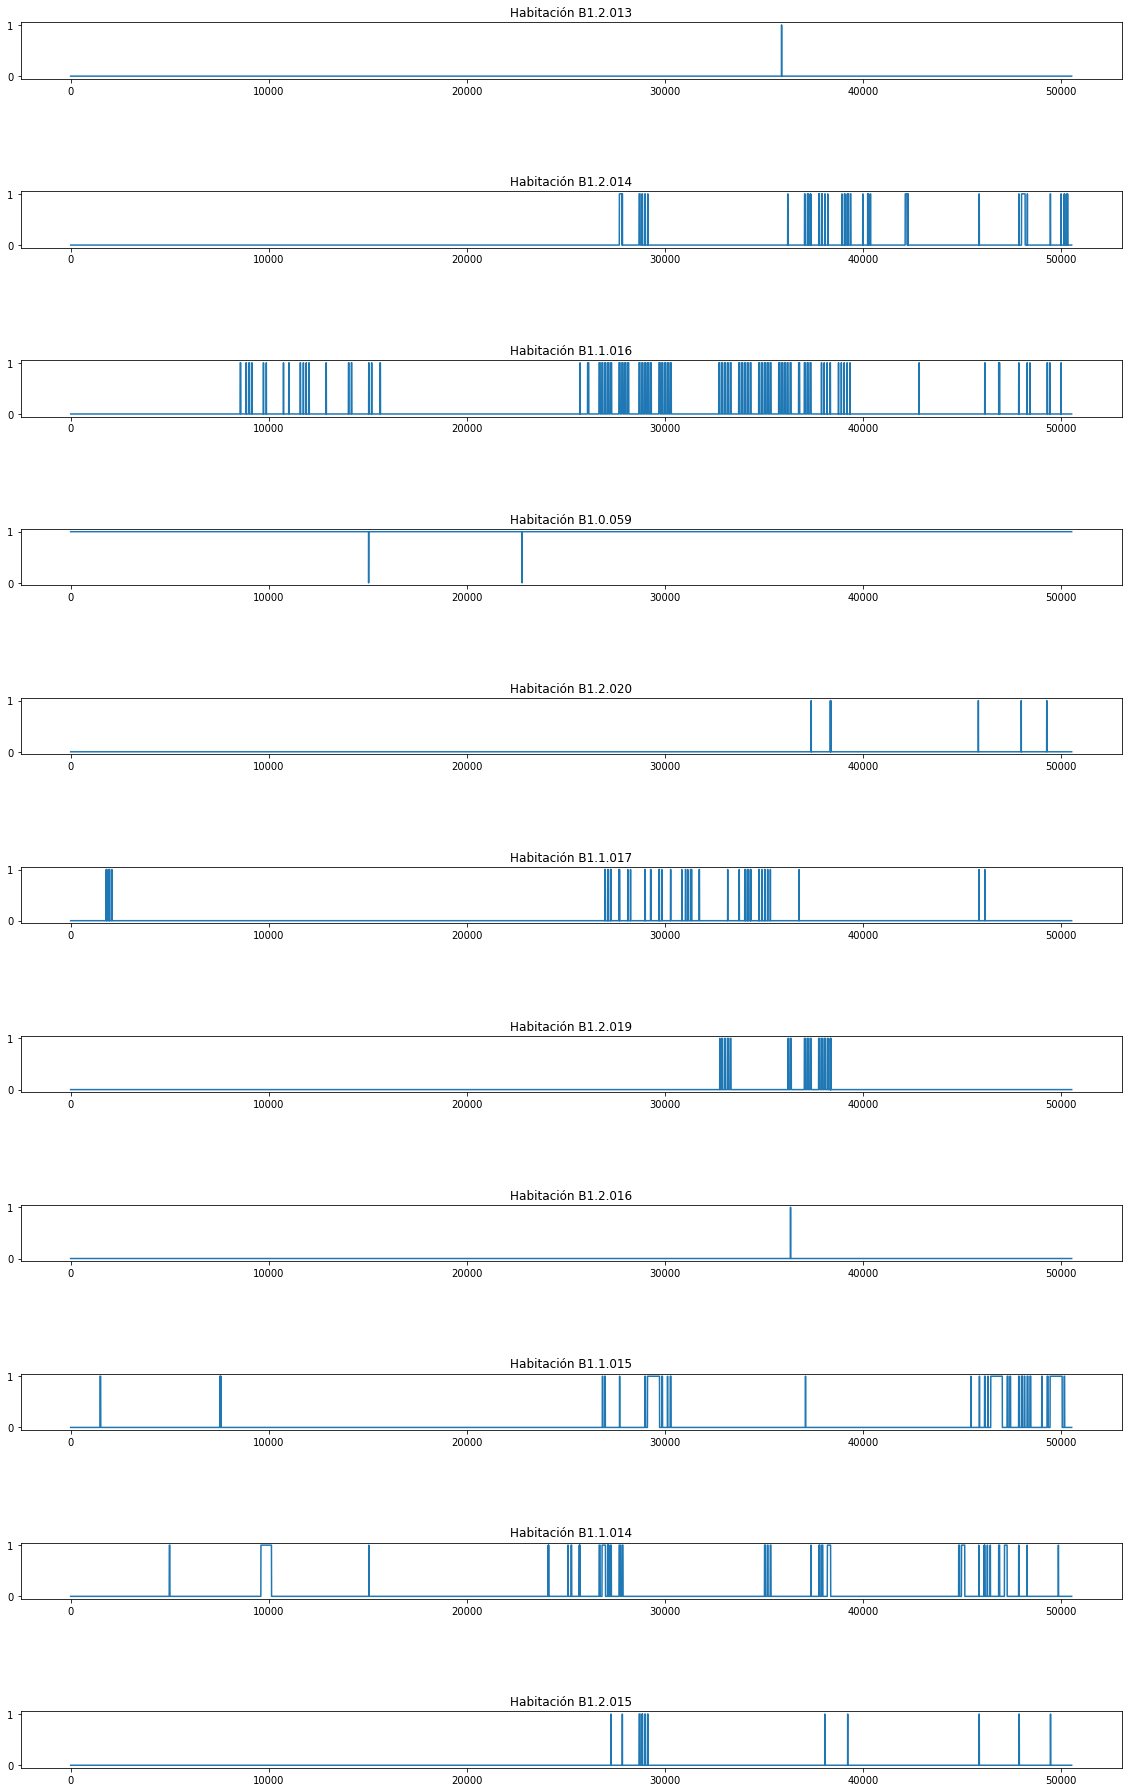

In [152]:
#Visualización del patrón ON/OFF de las habitaciones

rooms = rooms_B

#Hacemos un plot por cada habitación
fig, axes = plt.subplots(figsize=(16,25), nrows = len(rooms), ncols = 1, sharex=False, sharey= True)

for count,room in enumerate(rooms):
    mask = datos['room'].isin([room])
    datos_room = datos.loc[mask]
    datos_room['V4'].plot(ax=axes[count], use_index = False) #Si ponemos el index de fecha ocupa mucho y no se lee bien
    axes[count].set_title('Habitación ' + room)
fig.tight_layout()
#Para rotar los labels del eje x si lo ponemos con fecha, ya que sin rotar solapan
#for ax in fig.axes:
#    plt.sca(ax)
#    plt.xticks(rotation=0)
#Para aumentar el espaciado vertical entre gráficas
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=2)

In [153]:
df = pd.concat([datos[['dif_cons','room','V12','V2','tmed']].groupby('room').mean().rename(columns={'dif_cons':'dif_cons_mean', 'V12':'V12_mean', 'V2':'V2_mean', 'tmed':'tmed_mean'})
                , datos[['dif_cons','room','V12','V2','tmed']].groupby('room').std().rename(columns={'dif_cons':'dif_cons_sd', 'V12':'V12_sd', 'V2':'V2_sd', 'tmed':'tmed_sd'})], axis=1)
df = df[['dif_cons_mean', 'dif_cons_sd', 'V12_mean', 'V12_sd','V2_mean', 'V2_sd', 'tmed_mean','tmed_sd']]
df.head()

,dif_cons_mean,dif_cons_sd,V12_mean,V12_sd,V2_mean,V2_sd,tmed_mean,tmed_sd
room,,,,,,,,
B1.0.024,0.823317,1.195489,22.576452,0.776501,26.054446,2.807857,19.124032,7.615552
B1.0.025,0.823317,1.195489,22.506460,0.510008,25.878215,2.778222,19.124032,7.615552
B1.0.026,0.823317,1.195489,23.609277,0.251239,26.621019,2.902115,19.124032,7.615552
B1.0.059,0.443006,0.342934,22.297404,0.457120,24.788099,0.860458,19.124032,7.615552
B1.1.006,0.815964,0.597227,24.648682,3.812578,26.269205,3.810610,19.124032,7.615552


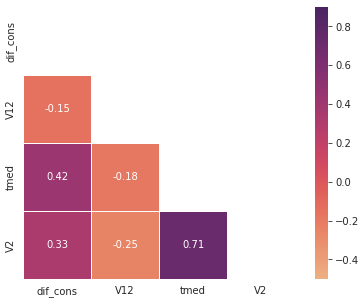

In [154]:
corr=datos[['dif_cons','V12', 'tmed', 'V2']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, 
                     xticklabels=corr, yticklabels=corr,
                     mask=mask, vmin=-0.5, vmax=0.9, square=True,
                     annot = True, linewidths=.5, cmap="flare")

In [155]:
datos_ON_A = datos.where((datos['V4']==1) & (datos['block'].isin(['A']))).dropna()
datos_ON_B = datos.where((datos['V4']==1) & (datos['block'].isin(['B']))).dropna()
datos_ON_C = datos.where((datos['V4']==1) & (datos['block'].isin(['C']))).dropna()
datos_OFF_A = datos.where((datos['V4']==0) & (datos['block'].isin(['A']))).dropna()
datos_OFF_B = datos.where((datos['V4']==0) & (datos['block'].isin(['B']))).dropna()
datos_OFF_C = datos.where((datos['V4']==0) & (datos['block'].isin(['C']))).dropna()

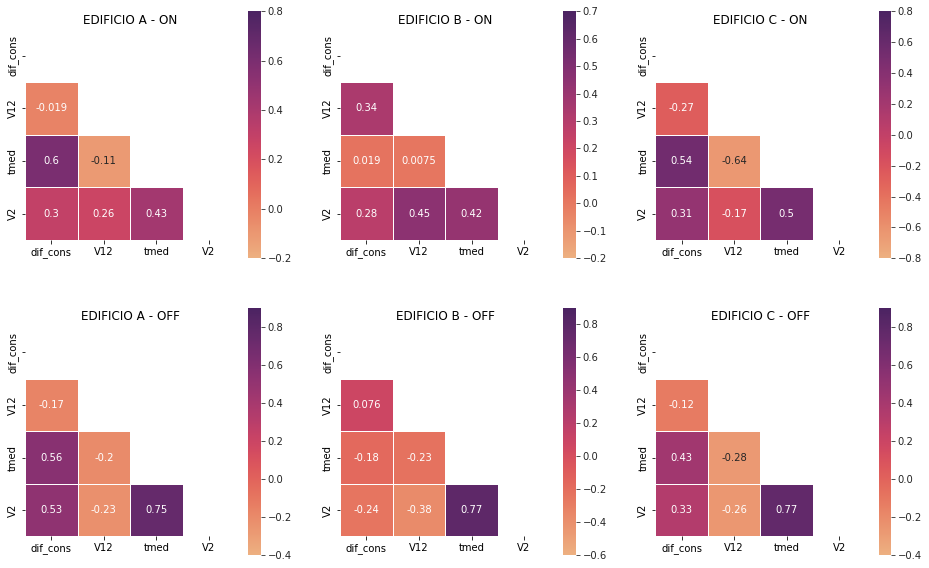

In [156]:
corr_ON_A=datos_ON_A[['dif_cons', 'V12', 'tmed', 'V2']].corr()
corr_ON_B=datos_ON_B[['dif_cons', 'V12', 'tmed', 'V2']].corr()
corr_ON_C=datos_ON_C[['dif_cons', 'V12', 'tmed', 'V2']].corr()
corr_OFF_A=datos_OFF_A[['dif_cons', 'V12', 'tmed', 'V2']].corr()
corr_OFF_B=datos_OFF_B[['dif_cons', 'V12', 'tmed', 'V2']].corr()
corr_OFF_C=datos_OFF_C[['dif_cons', 'V12', 'tmed', 'V2']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (16,10)) # width x height
ax1 = fig.add_subplot(2, 3, 1) # row, column, position
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4) 
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

with sns.axes_style("white"):
    ax1 = sns.heatmap(corr_ON_A, ax=ax1, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.2, vmax=0.8, 
                      square=True, annot = True, linewidths=.5, cmap="flare")
    ax1.set_title('EDIFICIO A - ON')
    ax2 = sns.heatmap(corr_ON_B, ax=ax2, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.2, vmax=0.7, 
                      square=True, annot = True, linewidths=.5, cmap="flare") 
    ax2.set_title('EDIFICIO B - ON') 
    ax3 = sns.heatmap(corr_ON_C, ax=ax3, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.8, vmax=0.8, 
                      square=True, annot = True, linewidths=.5, cmap="flare") 
    ax3.set_title('EDIFICIO C - ON')     
    ax4 = sns.heatmap(corr_OFF_A, ax=ax4, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.4, vmax=0.9, 
                      square=True, annot = True, linewidths=.5, cmap="flare")
    ax4.set_title('EDIFICIO A - OFF')
    ax5 = sns.heatmap(corr_OFF_B, ax=ax5, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.6, vmax=0.9, 
                      square=True, annot = True, linewidths=.5, cmap="flare") 
    ax5.set_title('EDIFICIO B - OFF') 
    ax6 = sns.heatmap(corr_OFF_C, ax=ax6, xticklabels=corr, yticklabels=corr, mask=mask, vmin=-0.4, vmax=0.9, 
                      square=True, annot = True, linewidths=.5, cmap="flare") 
    ax6.set_title('EDIFICIO C - OFF') 


- Hay una alta correlación entre tmed y V2, algo que tiene sentido dado que la temperatura exterior va a condicionar la interior medida por el sensor.
- En el edificio A el consumo está correlacionado con tmed (y también con V2)
- En el edificio C hay correlación negativa entre tmed y V12 cuando está ON, esto se puede entender porque el hvac se estará usando de forma que si fuera hace calor dé aire frío, y si hace frío, dé el aire caliente.
- No se ve correlación entre el dif_cons y V12, un hecho un tanto extraño ya que se podría esperar que el setpoint sí condicionase el consumo.

### datos-model-cons

Preparación de los ficheros para los modelos de consumo.
Después se representan V4 y dif_cons y se calcula su correlación

In [20]:
def data_model_cons(ids_edificio, edificio, datos_cons, datos_hvac, datos_temp, datos_weather, interval):
    data = datos_cons
    hvac = datos_hvac
    temp = datos_temp
    weather = datos_weather
    hvac['Fecha'] =  pd.to_datetime(hvac['Fecha'], utc = True)
    temp['Fecha'] =  pd.to_datetime(temp['Fecha'], utc = True)
    weather['Fecha'] =  pd.to_datetime(weather['Fecha'], utc = True)
    ids = ids_edificio
    #Nos quedamos solo con uno de los edificios
    mask = data['IDdispositivo'].isin(ids)
    df = data.loc[mask]
    df = df.iloc[::-1]
    #Creamos una columna que sea la diferencia de consumo entre t y t-1
    df.insert(2, "dif_cons", df['V22'].diff(), True)
    df = df.set_index('Fecha')
    df.index = pd.to_datetime(df.index, utc = True)
    #Hacemos un remuestreo cada <interval> (10|30|60 min)
    df = df.resample(interval)['dif_cons'].sum().to_frame()
    
    df = pd.merge(df, temp, left_on="Fecha", right_on="Fecha")
    df = pd.merge(df, hvac, left_on="Fecha", right_on="Fecha")
    df = pd.merge(df, weather, left_on="Fecha", right_on="Fecha")
    df = df.set_index('Fecha')
    
    #Paso 1: quitar las filas en las que hay secuencias de 0's y picos que no se pueden justificar
    df = df.where(df['dif_cons']>0).dropna()
    df = df.where(df['dif_cons']<25).dropna()
    
    #Paso 2: quitar las filas en las que el número de hvacs encendidos sea menor que 2
    #Solo lo aplicamos a A y B, en C la mayoría son <2 y se queda casi sin observaciones
    if edificio == 'A' or edificio == 'B':
        df = df.where(df['V4']>2).dropna()    
    
    #Paso 3: suavizar el dif_cons: con ewm(exponential weighted moving average) (sale lo mismo que rolling pero sin nulos)
    #Ventana de 6 observaciones
    df['dif_cons'] = df['dif_cons'].ewm(span = 6).mean()
    
    #Paso 4: suavizar el V4 de la misma forma
    df['V4'] = df['V4'].ewm(span = 6).mean().round(0)
    
    df = df.round({'dif_cons': 2})
    df = df.round({'V2': 2})
    #Fijamos el límite de la fecha hasta cuando tenemos datos meteorológicos
    mask = (df.index >= '2021-01-01 00:00:00') & (df.index <= '2021-12-18 00:00:01')
    df = df.loc[mask]
    df = df.reset_index()
    
    df.to_csv('data-model-consumo' + edificio + '-' + res_time + '.csv', sep=";")
    
    return df

In [29]:
res_time = '120T'
edificio = 'C'
id_edificio = 335546927  # 335546926 (B), 335546927 (C), 335546928 (A)

In [30]:
data = pd.read_csv('data-cons.csv')
hvac_mixed = pd.read_csv('hvac-mixed' + edificio + '-' + res_time + '.csv', sep=";")
temp_sensor = pd.read_csv("temp-sensor" + edificio +"-"+ res_time + ".csv", sep=";")
weather = pd.read_csv('data-meteo-' + res_time + '.csv', sep=';')

In [31]:
consumo = data_model_cons([id_edificio], edificio, data, hvac_mixed, temp_sensor, weather, res_time)

In [32]:
print(consumo.shape)
consumo.head(3)

(3691, 24)


,Fecha,dif_cons,V2,V4,V12,V26,V5_0,V5_1,V5_2,Hora_1,...,Season_3,Season_4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
0,2021-01-01 02:00:00+00:00,1.35,22.51,0.0,25.14,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,3.3,67.4,0.0,0.2,193.6,0.0,-2.1,0.3
1,2021-01-01 04:00:00+00:00,1.35,22.32,0.0,25.14,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4.9,62.6,0.0,0.5,193.5,0.0,-1.7,0.3
2,2021-01-01 06:00:00+00:00,1.35,22.33,0.0,25.14,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,6.6,72.5,2.2,0.8,196.4,0.0,1.9,0.3


In [54]:
modelconsA = pd.read_csv('data-model-consumoA-' + res_time + '.csv', sep=";", index_col=0)
modelconsB = pd.read_csv('data-model-consumoB-' + res_time + '.csv', sep=";", index_col=0)
modelconsC = pd.read_csv('data-model-consumoC-' + res_time + '.csv', sep=";", index_col=0)

In [55]:
modelconsA

,Fecha,dif_cons,V2,V4,V12,V26,V5_0,V5_1,V5_2,Hora_1,...,Season_3,Season_4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
0,2021-01-07 10:00:00+00:00,1.80,20.74,3.0,23.47,0.1,0.0,1.0,0.0,1.0,...,0.0,0.0,4.8,88.1,53.5,0.2,214.5,0.1,3.0,0.1
1,2021-01-07 10:10:00+00:00,1.84,20.78,4.0,23.47,0.1,0.0,1.0,0.0,1.0,...,0.0,0.0,5.0,88.2,56.4,0.3,251.2,0.1,3.2,0.1
2,2021-01-07 10:20:00+00:00,1.70,20.83,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,5.0,88.2,45.2,0.4,195.8,0.1,3.2,0.1
3,2021-01-07 10:30:00+00:00,1.60,20.85,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,4.9,88.2,38.2,0.5,217.9,0.1,3.1,0.1
4,2021-01-07 10:40:00+00:00,2.55,20.82,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,4.9,88.2,45.0,0.7,182.4,0.1,3.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42026,2021-12-17 23:10:00+00:00,0.26,24.05,6.0,23.84,0.2,0.0,0.0,1.0,0.0,...,0.0,1.0,12.1,74.1,0.0,0.0,91.0,0.0,7.6,0.4
42027,2021-12-17 23:20:00+00:00,0.22,24.04,6.0,23.84,0.2,0.0,0.0,1.0,0.0,...,0.0,1.0,12.1,74.3,0.0,0.0,36.9,0.0,7.7,0.4
42028,2021-12-17 23:30:00+00:00,0.24,24.05,6.0,23.84,0.2,0.0,0.0,1.0,0.0,...,0.0,1.0,12.0,75.3,0.0,0.0,0.0,0.0,7.8,0.3
42029,2021-12-17 23:40:00+00:00,0.21,24.04,6.0,23.84,0.2,0.0,0.0,1.0,0.0,...,0.0,1.0,12.1,76.1,0.0,0.0,0.0,0.0,8.0,0.3


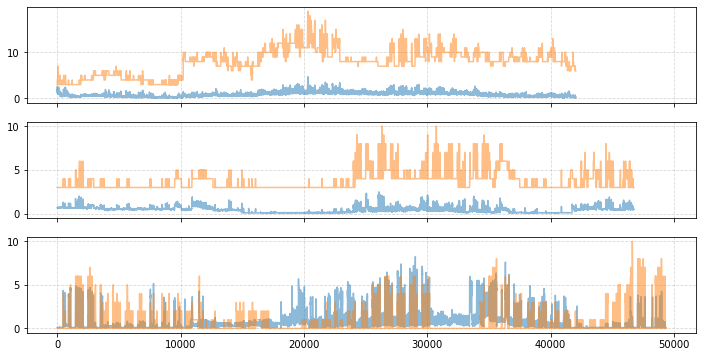

In [21]:
fig,axs = plt.subplots(figsize=(12,6), nrows = 3, ncols =1, sharex =True)
axs[0].plot(modelconsA['dif_cons'], alpha=0.5)
axs[0].plot(modelconsA['V4'], alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.5)
axs[1].plot(modelconsB['dif_cons'], alpha=0.5)
axs[1].plot(modelconsB['V4'], alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.5)
axs[2].plot(modelconsC['dif_cons'], alpha=0.5)
axs[2].plot(modelconsC['V4'], alpha=0.5)
axs[2].grid(linestyle = "--", alpha=0.5)

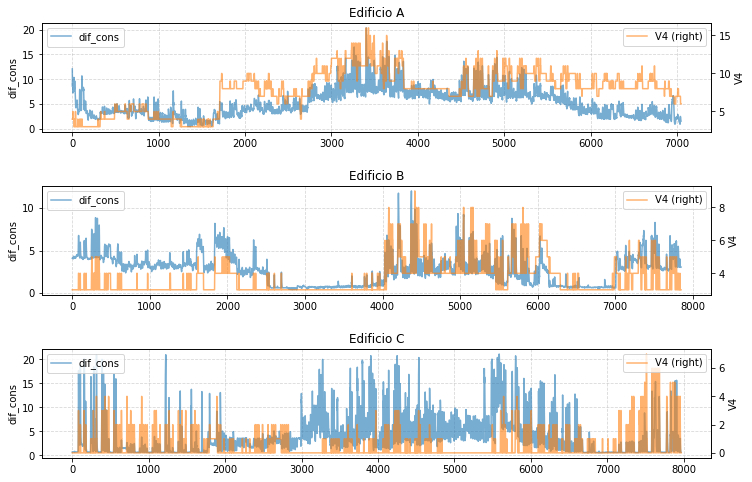

In [51]:
fig, axes = plt.subplots(figsize=(12,8), nrows = 3, ncols = 1, sharex=False, sharey= False)

axes[0].set_title('Edificio A')
modelconsA['dif_cons'].plot( ax=axes[0], use_index=False, ylabel='dif_cons', alpha=0.6)
ax = modelconsA['V4'].plot(ax=axes[0], secondary_y=['V4'], use_index=False, alpha=0.6)
ax.set_ylabel('V4')
axes[0].legend(['dif_cons'], loc='upper left')
plt.legend(loc = 'upper right')
axes[0].grid(linestyle = "--", alpha=0.5)

axes[1].set_title('Edificio B')
modelconsB['dif_cons'].plot( ax=axes[1], use_index=False, ylabel='dif_cons', alpha=0.6)
ax = modelconsB['V4'].plot(ax=axes[1], secondary_y=['V4'], use_index=False, alpha=0.6)
ax.set_ylabel('V4')
axes[1].legend(['dif_cons'], loc='upper left')
plt.legend(loc = 'upper right')
axes[1].grid(linestyle = "--", alpha=0.5)

axes[2].set_title('Edificio C')
modelconsC['dif_cons'].plot( ax=axes[2], use_index=False, ylabel='dif_cons', alpha=0.6)
ax = modelconsC['V4'].plot(ax=axes[2], secondary_y=['V4'], use_index=False, alpha=0.6)
ax.set_ylabel('V4')
axes[2].legend(['dif_cons'], loc='upper left')
plt.legend(loc = 'upper right')
axes[2].grid(linestyle = "--", alpha=0.5)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [43]:
#corrs= pd.DataFrame()

In [52]:
df = pd.DataFrame({'edificio':['A','B','C'], 'res_time': res_time,
              'corr': [modelconsA[['dif_cons','V4']].corr().iloc[0,1], modelconsB[['dif_cons','V4']].corr().iloc[0,1], modelconsC[['dif_cons','V4']].corr().iloc[0,1]]})

corrs = pd.concat([corrs,df])
corrs

,edificio,res_time,corr
0,A,10T,0.683229
1,B,10T,0.544726
2,C,10T,0.514199
0,A,30T,0.698511
1,B,30T,0.536896
2,C,30T,0.504820
0,A,60T,0.698247
1,B,60T,0.513353
2,C,60T,0.286563
